In [52]:
# %load main.py
from sklearn.cluster import KMeans, MeanShift
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from parallel_pandas import ParallelPandas
#Probably want to add a year scaling function to the number of bins (This was not done and probably will never be done)
def graph_patents(df, patentnumber):
    cdmapatent = df.loc[df['Pub'] == patentnumber]
    graphlist = cdmapatent['Cited_Date'].to_list()
    #print(graphlist)
    graphlist = [str(x) for x in graphlist]
    graphlist = [int(x[:4]) for x in graphlist]
    n,bins,patches = plt.hist(graphlist,bins = 15, width = 0.75)
    plt.title("Patent Citations for US Patent " +  patentnumber)
    plt.xlabel("Year")
    plt.ylabel("Number of Citations")
    plt.xlim([1990,2023])
    #plt.savefig(patentnumber +".png")
    plt.show()
#Cutoff refers to the the amount of time it took for a given patent to receive X citations
def sanitize(date):
    date = int(str(date)[:4])
    return date
def find_time(df, patentnumber, cutoff):
    patent = df.loc[df['Pub'] == patentnumber]
    datelist = patent['Cited_Date'].to_list()
    datelist = sorted(datelist)
    datelist = datelist[:cutoff]
    newint = sanitize(datelist[cutoff-1])-sanitize(datelist[0])
    return newint
def find_time_percentile(df, patentnumber, percentile):
    
    patent = df.loc[df['Pub'] == patentnumber]
    datelist = patent['Cited_Date'].to_list()
    datelist = sorted(datelist)
    range = round(len(datelist) * percentile * 0.01)
    newint = sanitize(datelist[range])-sanitize(datelist[0])
    return newint
def quantileranges(percentile, year1, year2):
    df = pd.read_csv("/home/jayden/Code/PatentAnalysis/patent_results"+year1+"-"+year2+".csv")
    counts = df['Pub'].value_counts().to_frame()
    print(counts[:10])
    #counts  = counts.where(counts.gt(counts.quantile(percentile))).stack().sort_index()
    #counts.to_csv("patent_results" + year1+"-"+year2+ str(percentile)+"percentile.csv")

def find_last(df, patentnumber,lastnumber):
    patent = df.loc[df['Pub'] == patentnumber]
    datelist = patent['Cited_Date'].to_list()
    datelist = sorted(datelist)
    datelist = datelist[-lastnumber:]
    return 2023-sanitize(datelist[0])
   



In [135]:
ParallelPandas.initialize(n_cpu = 8, split_factor =4, disable_pr_bar = False)
#Set the bucket of data here
df = pd.read_csv("/home/jayden/Code/PatentAnalysis/patent_results1994-1996.csv")



In [136]:
counts = df['Pub'].value_counts()
#value_counts returns a series in key-value form which is undesirable
#The code below should convert it into a usable form
templist = counts.axes[0]
templist1 = counts.values
total = pd.DataFrame()
total['Pub'] = templist
total['Counts'] = templist1
total = total[total['Counts'] >= 1500]
print(total)


              Pub  Counts
0    US-5585089-A    6357
1    US-5523520-A    5679
2    US-5693762-A    4556
3    US-5625126-A    3784
4    US-5545807-A    3764
..            ...     ...
268  US-5722891-A    1507
269  US-5875108-A    1506
270  US-5632272-A    1503
271  US-5511564-A    1503
272  US-5904693-A    1501

[273 rows x 2 columns]


In [137]:
breakthroughs = total['Pub'].to_list()

In [145]:
#It might be useful to store this data in a file
#The code here can be customized to find how long it took to reach the Xth percentile of citations
timetobreakthrough = pd.DataFrame(columns = ['Pub','Time'])
for i in breakthroughs:
    temp = []
    temp.append(i)
    #temp.append(find_last(df,i,100))
    temp.append(find_time_percentile(df, i , 10))
    #temp.append(find_time(df, i,1000))
    timetobreakthrough.loc[len(timetobreakthrough)] = temp
print(timetobreakthrough)


              Pub  Time
0    US-5585089-A    12
1    US-5523520-A     8
2    US-5693762-A    12
3    US-5625126-A     6
4    US-5545807-A    11
..            ...   ...
268  US-5722891-A     6
269  US-5875108-A     6
270  US-5632272-A     9
271  US-5511564-A    15
272  US-5904693-A     9

[273 rows x 2 columns]


In [146]:
#Differentiation here need to be made for counting until X citations and counting until the Xth percentile of citations
timetobreakthrough.to_csv("1994-1996/time_1_1994-1996.csv")
#timetobreakthrough.to_csv("time1998-2000.csv")

In [67]:
for i in breakthroughs:
    graph_patents(df, i)

In [160]:
#Trying out some clustering here, this is all set up
def cpc_times_cleanup(startyear, tag):
    cpc_codes = pd.read_csv(str(startyear) + "-" + str(startyear+2) + "/patent_cpc_code" + str(startyear) + "-" + str(startyear+2) + ".csv")
    cpc_codes = cpc_codes.drop_duplicates(subset = ["Pub"])
    #Label Binarization
    labels = cpc_codes['cpc'].to_list()
    lb = LabelBinarizer()
    lb.fit(labels)
    newarr = lb.transform(labels)
    print(len(newarr[0]))
    binarized = []
    count = 0
    for i in newarr:
        #temp = []
        #temp.append(i)

        binarized.append(i.tolist().index(1))
        #count +=1
    print(binarized[0])
    cpc_codes['cpc'] = binarized
    patent_times = pd.read_csv(str(startyear) + "-" + str(startyear+2) + "/time" + tag + str(startyear) + "-" + str(startyear+2) + ".csv")
    patent_times = patent_times.drop("Unnamed: 0", axis = 1)
    unified = patent_times.merge(cpc_codes, on = "Pub")
    unified = unified.drop_duplicates(subset = ["Pub"])
    return unified, lb

In [5]:
def remove_cpc(input):
    input = input.drop(columns = ['cpc', 'Time'],axis = 1)
    return input

In [148]:
#Actual clustering starts here 
#There is 100% a better way to do this
def setup_cluster(year):
    times_10, labels = cpc_times_cleanup(year, '_1_')
    times_10['Times_10'] = times_10['Time']
    times_10 = remove_cpc(times_10)
    print(times_10)
    times, labels = cpc_times_cleanup(year, '')
    times_90, labels = cpc_times_cleanup(year, '_2_')
    times_90['Times_90'] = times_90['Time']
    times_90 = remove_cpc(times_90) 
    last_100, labels = cpc_times_cleanup(year, '_3_')
    last_100['Last_100'] = last_100['Time']
    last_100 = remove_cpc(last_100)
    clustering_unified = times.merge(times_10, on = "Pub")
    clustering_unified = clustering_unified.merge(times_90, on = "Pub")  
    clustering_unified = clustering_unified.merge(last_100, on = "Pub")
    clustering_backup = clustering_unified
    clustering_unified = clustering_unified.drop(columns = "Pub")
    clustering_backup.to_csv(str(year) + '-' + str(year+2) + "/clustering" + str(year)+"-"+str(year+2) + ".csv")
    return labels
#kmeans = MeanShift()


In [161]:
lb = setup_cluster(1994)
print(lb)

195
108
              Pub  Times_10
0    US-5585089-A        12
1    US-5523520-A         8
2    US-5693762-A        12
3    US-5625126-A         6
4    US-5545807-A        11
..            ...       ...
266  US-5722891-A         6
267  US-5875108-A         6
268  US-5632272-A         9
269  US-5511564-A        15
270  US-5904693-A         9

[271 rows x 2 columns]
195
108
195
108
195
108
LabelBinarizer()


In [167]:
def convert_to_cpc(lb, input, length):
    test = np.zeros(length).reshape(1,length)
    test[0][input] = 1
    return lb.inverse_transform(test)

In [175]:
clustering_unified = pd.read_csv("1990-1992/clustering1990-1992.csv")
clustering_1 = pd.read_csv("1992-1994/clustering1992-1994.csv")
clustering_unified = pd.concat([clustering_unified, clustering_1])
clustering_backup = clustering_unified
print(clustering_unified)
converted_cpc = clustering_unified["cpc"].to_list()
clustering_unified = clustering_unified.drop(columns = ["Pub", "Unnamed: 0","cpc"],axis = 1)

     Unnamed: 0           Pub  Time  cpc  Times_10  Times_90  Last_100
0             0  US-5223409-A    13   55        12        20         1
1             1  US-5530101-A    15   48        12        20         2
2             2  US-5225539-A    18   51        16        24         1
3             3  US-5569825-A    14   54        11        19         2
4             4  US-5143854-A    12   45         8        15         4
..          ...           ...   ...  ...       ...       ...       ...
169         169  US-5454101-A    23  114        23        25         4
170         170  US-5423471-A    23   10        23        26         3
171         171  US-5352238-A    22   27        22        25         3
172         172  US-5490505-A    19   67        19        25         4
173         173  US-5422567-A    22   55        22        24         3

[256 rows x 7 columns]


In [176]:
#kmeans = MeanShift()
kmeans = KMeans(n_clusters = 3, random_state = 0, n_init = "auto")
label = kmeans.fit_predict(clustering_unified)
print(label)

[2 2 2 2 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1
 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 0 1 1 1 0 0 1 1 2 2 2 2 2 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 2 0 2 2 0 0 0 2
 2 0 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0 0 2 0 0 2 0 0 2 0 0 0 0 0 0 2 0 0 0 2 0
 2 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 2 0 0 0 0 0 0 2 0 0 0 2 0 0 0 2 0 2 0 0 0
 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0
 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0]


In [ ]:
#Writing a combination function for the biggest files here
def combine_range(start, end):
    

US-5084057-A
['A61B17/068']


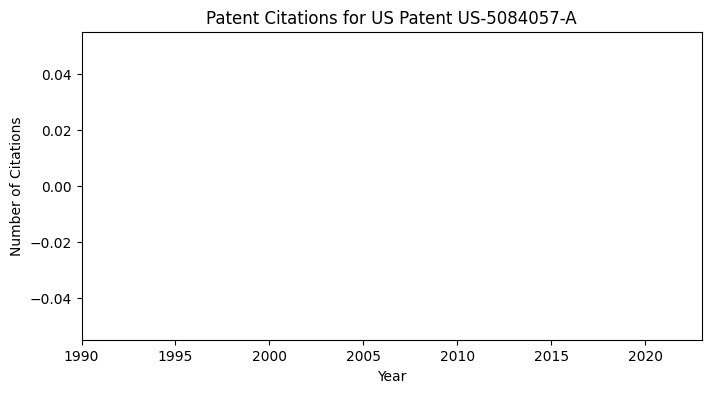

US-5129570-A
['A61B17/1697']


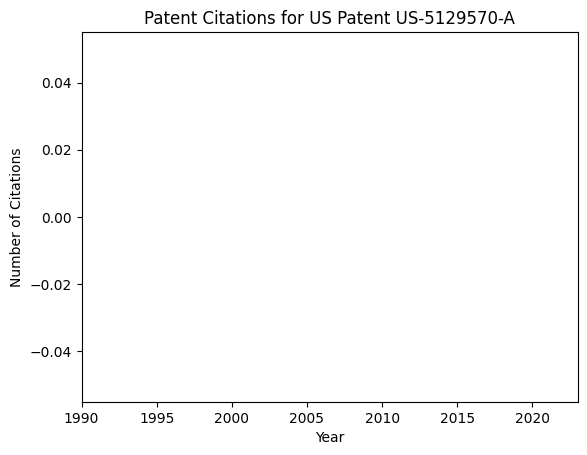

US-5065929-A
['A61B17/0491']


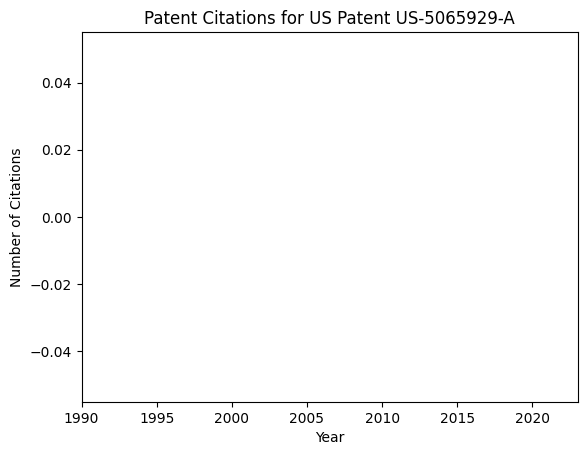

US-5289963-A
['A61B17/1285']


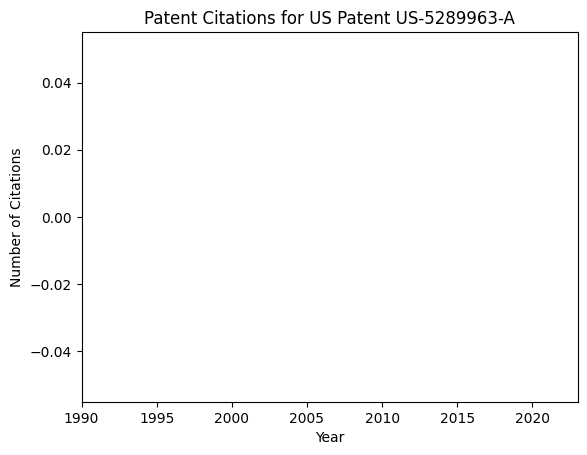

US-5171247-A
['A61B17/147']


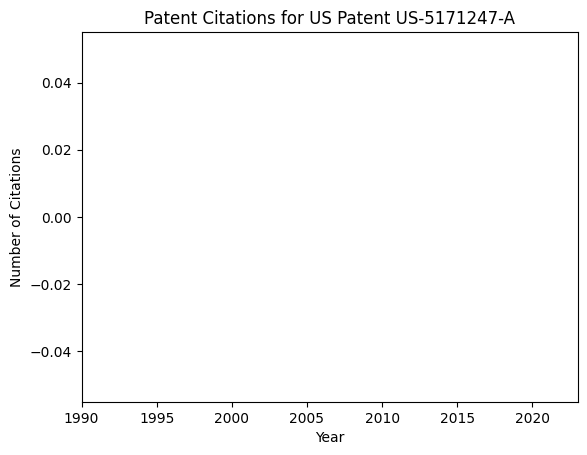

US-5253793-A
['A61B17/11']


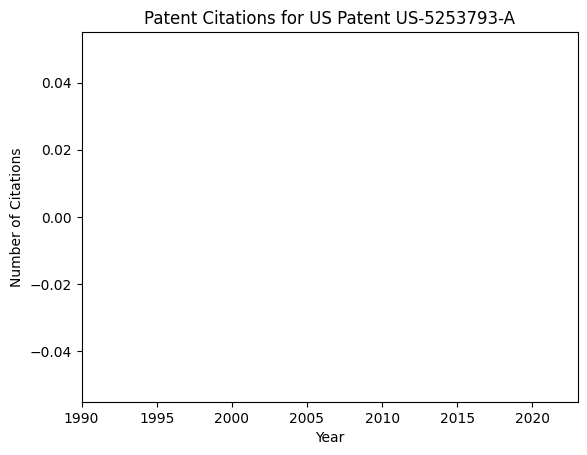

US-5156315-A
['A61B17/3403']


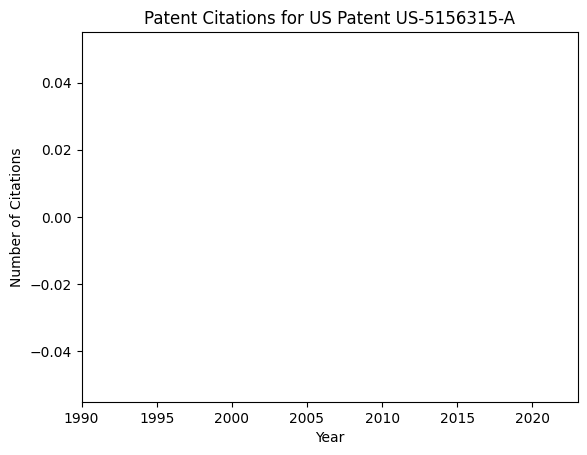

US-5014899-A
['A61B17/12109']


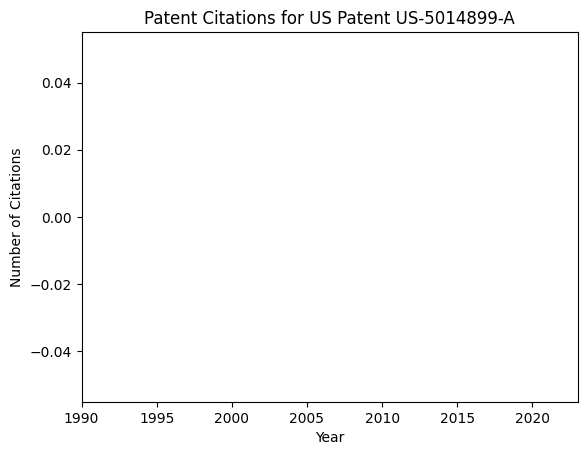

US-5282829-A
['A61B1/00174']


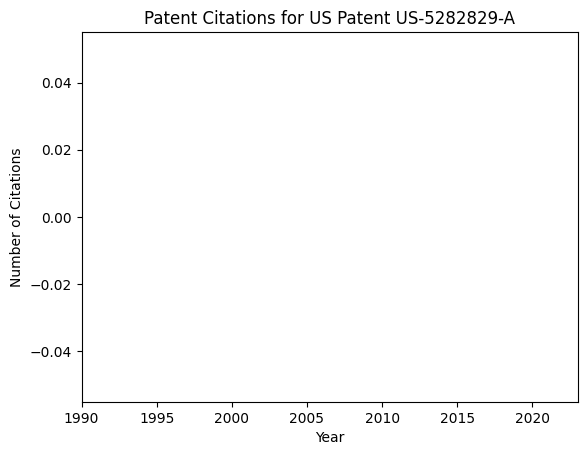

US-5111987-A
['A61B17/0491']


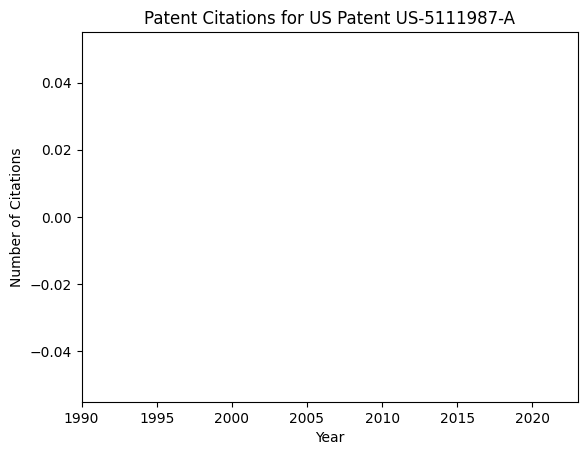

US-5015227-A
['A61B17/083']


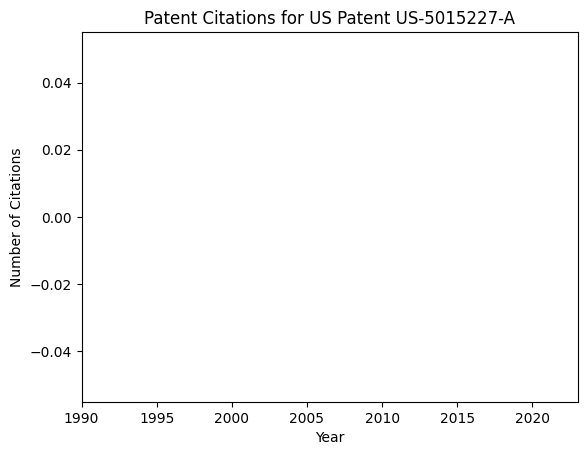

US-5083695-A
['A61B17/0491']


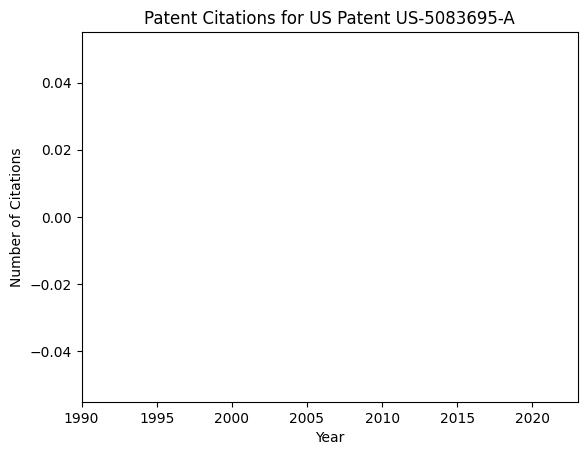

US-5141144-A
['A61B17/0491']


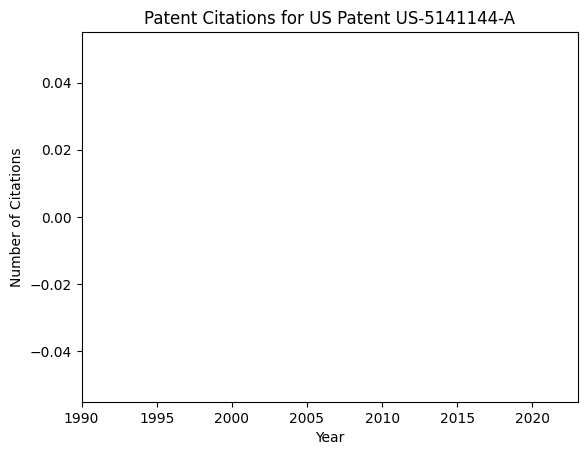

US-5122156-A
['A61B17/0642']


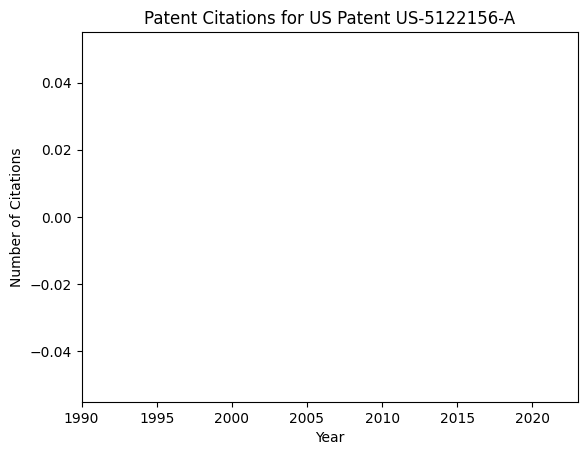

US-5074454-A
['A61B17/0491']


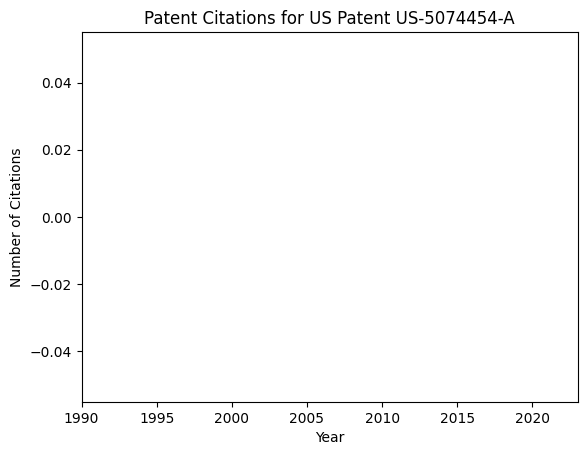

US-5246156-A
['A61B10/0266']


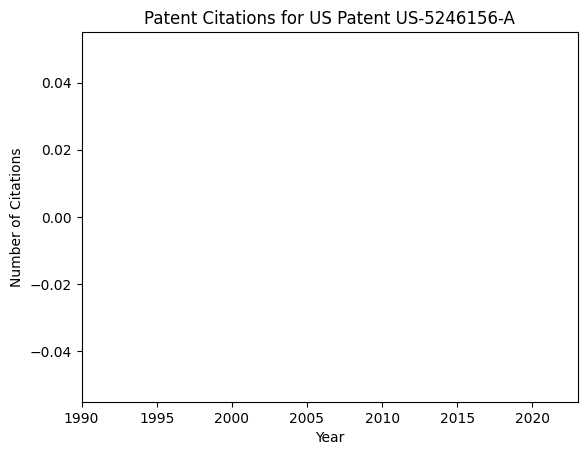

US-5139513-A
['A61B17/0642']


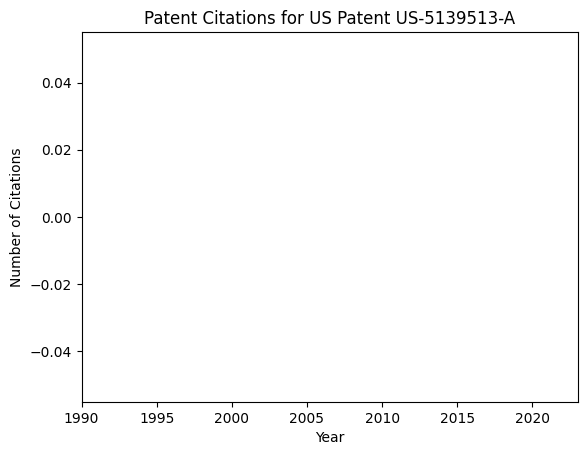

US-5171249-A
['A61B17/068']


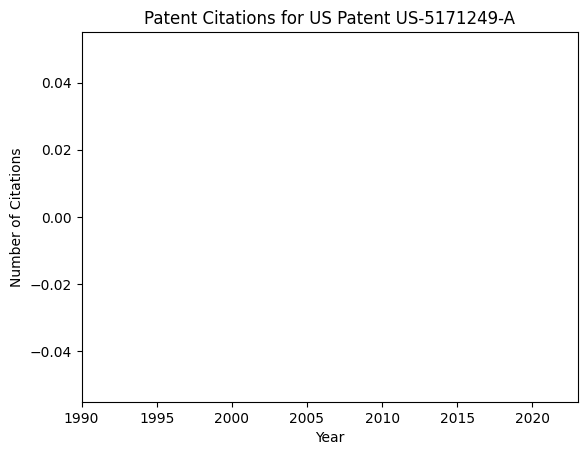

US-5088997-A
['A61B17/282']


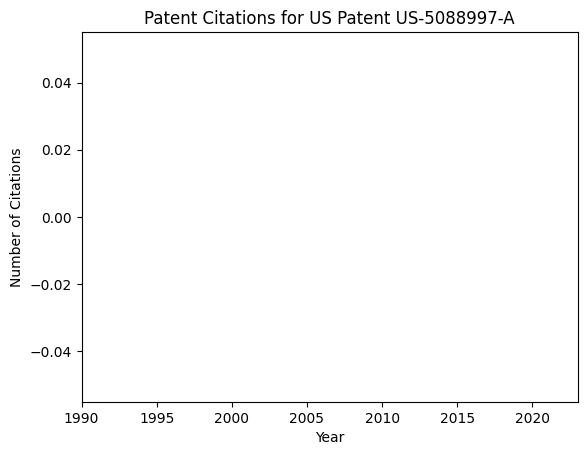

US-5137198-A
['A61B17/866']


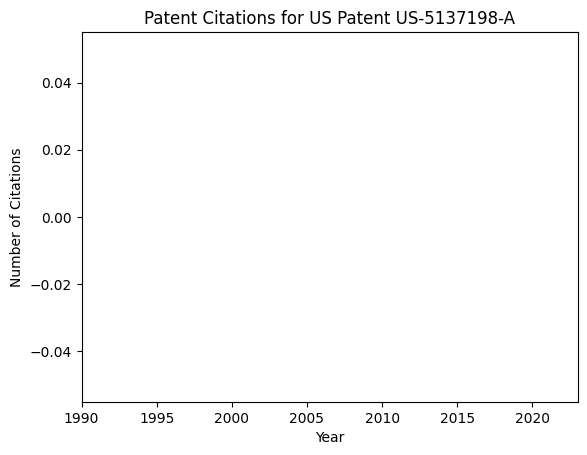

US-5485474-A
['A61B2017/2936']


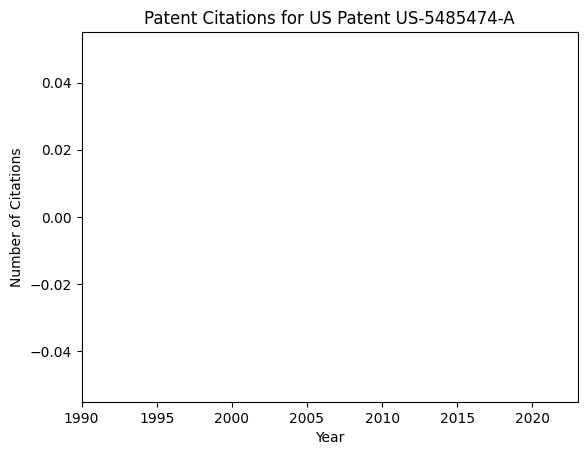

US-5031814-A
['A61B17/0491']


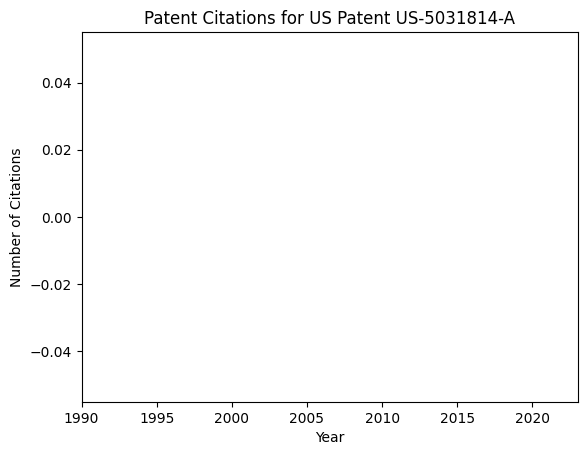

US-5156614-A
['A61B17/0491']


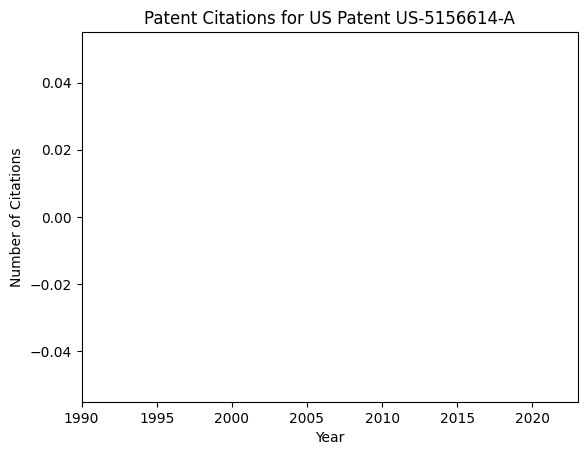

US-5222976-A
['A61B17/1155']


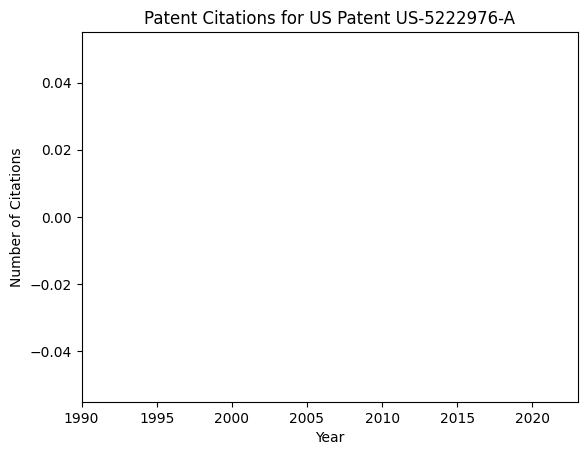

US-5116349-A
['A61B17/04']


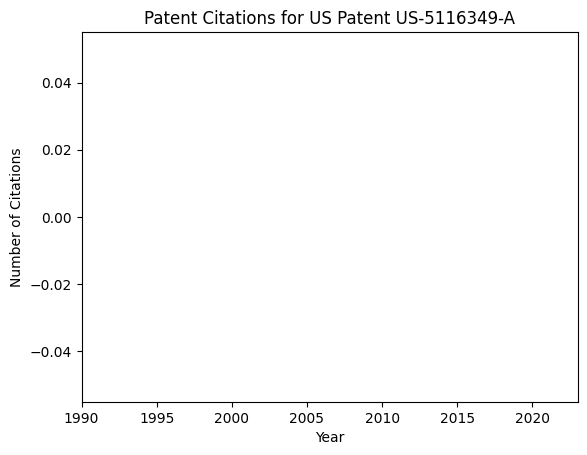

US-5106008-A
['A61B17/0491']


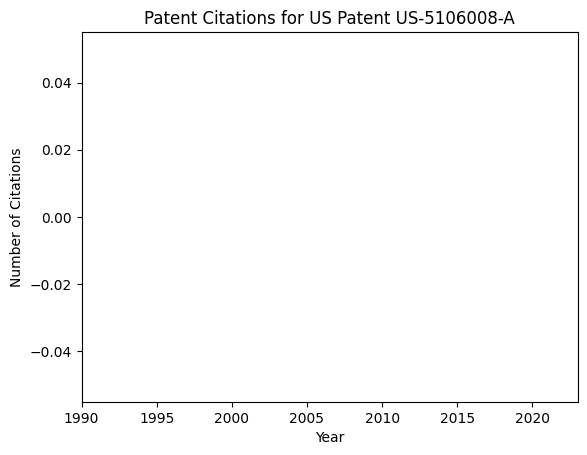

US-5197648-A
['A61B17/0642']


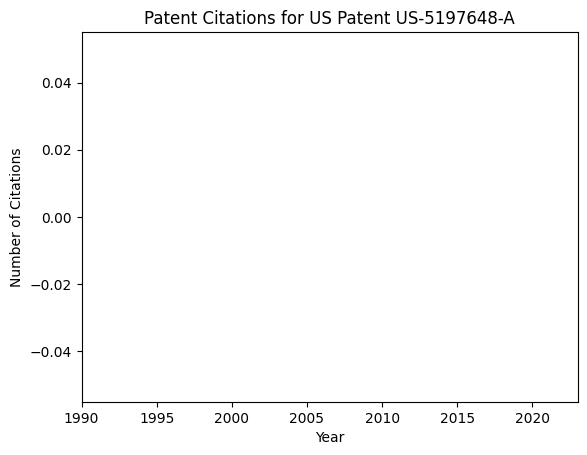

US-5009661-A
['A61B17/320783']


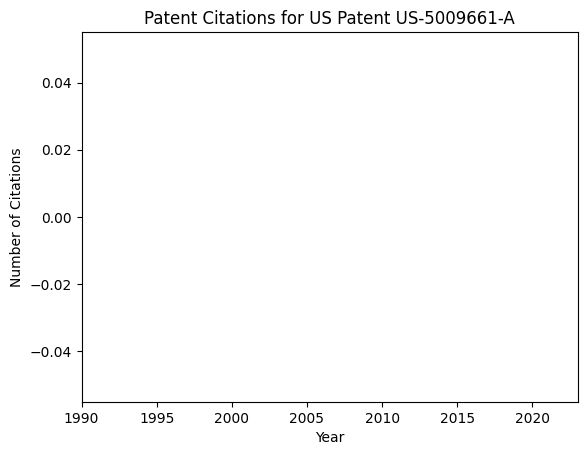

US-5821337-A
['A61K38/00']


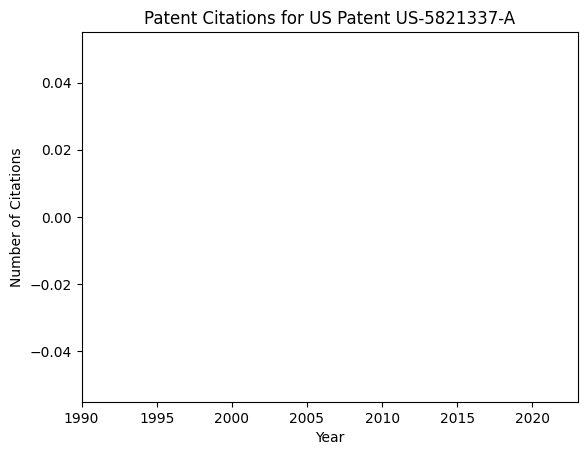

US-5383880-A
['A61B2017/00292']


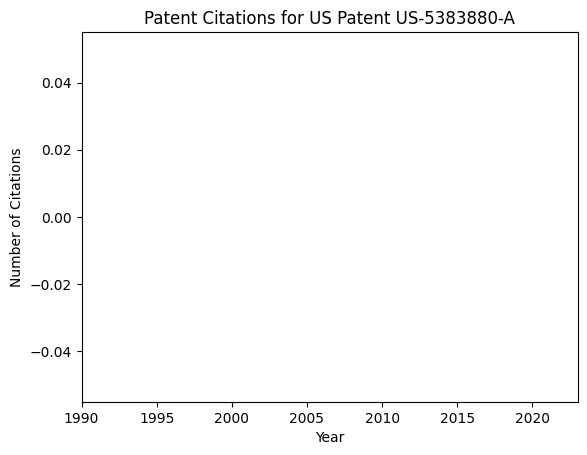

US-5312023-A
['A61B2017/00446']


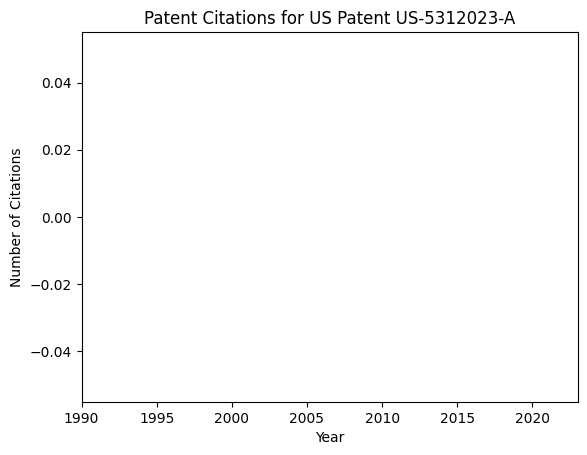

US-5389098-A
['A61B2017/2926']


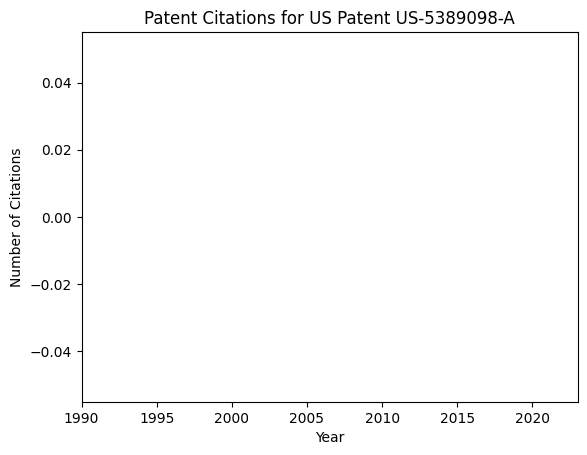

US-5433721-A
['A61B17/00234']


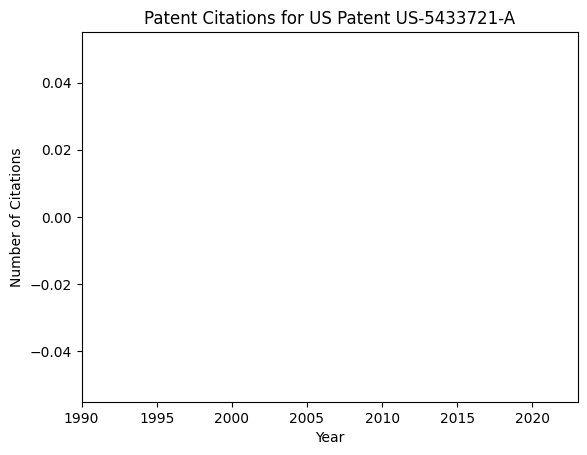

US-5205459-A
['A61B17/072']


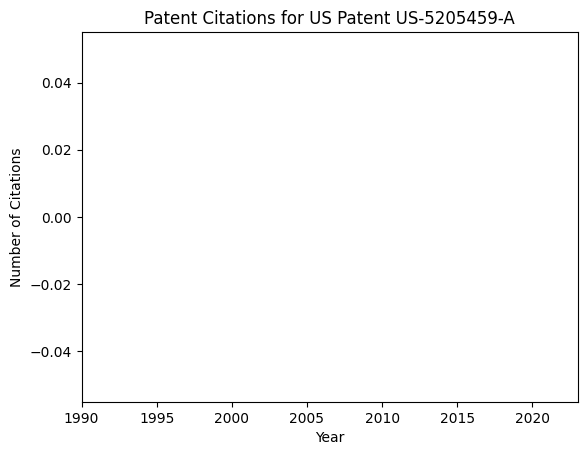

US-5307976-A
['A61B2017/0003']


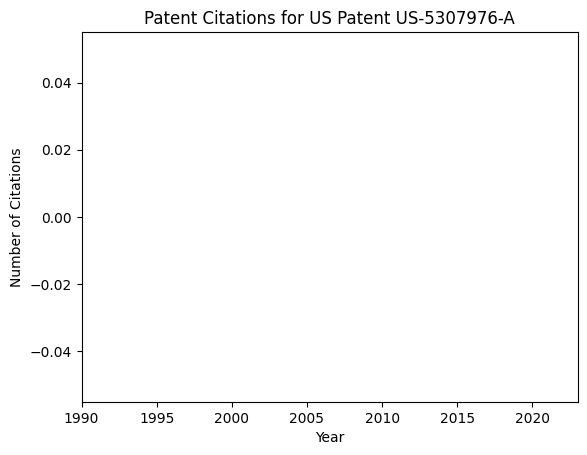

US-5403484-A
['A61M2205/6018']


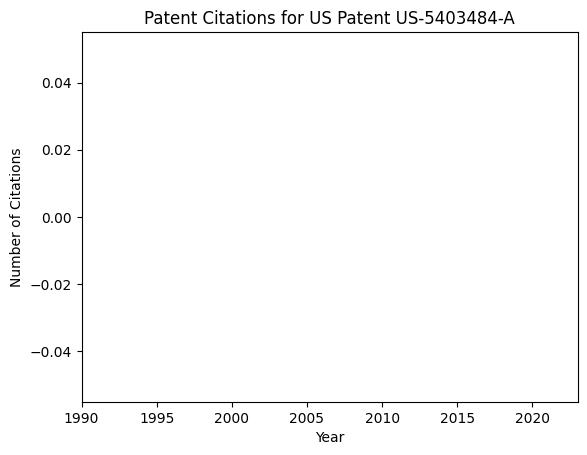

US-5497933-A
['A61B17/064']


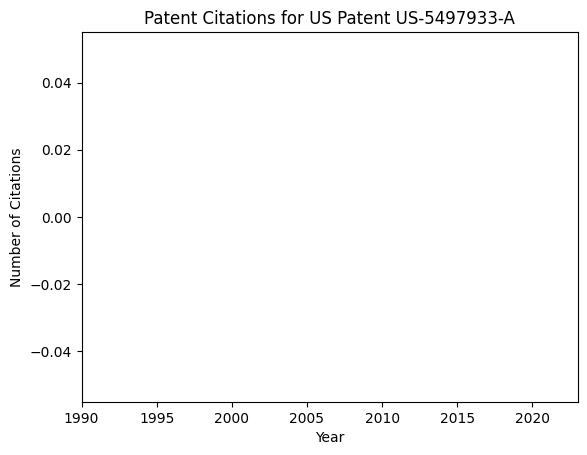

US-5415334-A
['A61B17/1155']


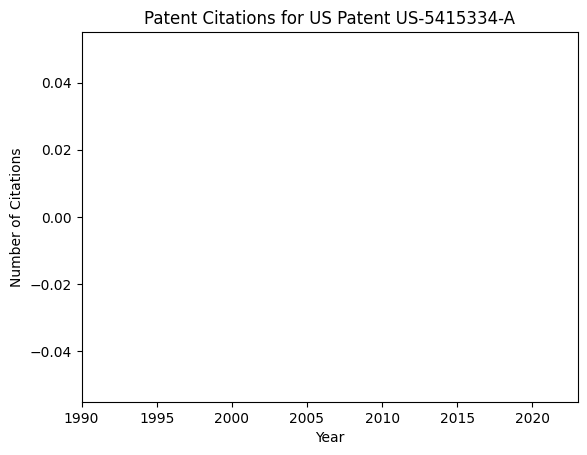

US-5285945-A
['A61B2017/00292']


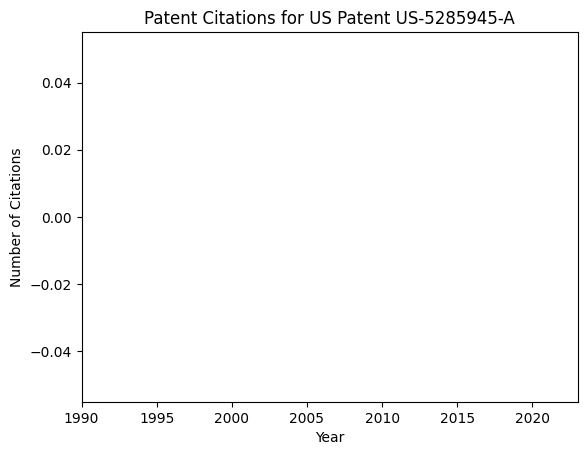

US-5542594-A
['A61B17/0682']


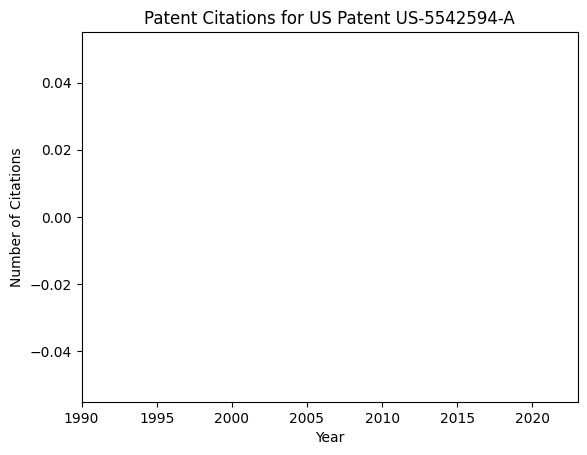

US-5395030-A
['A61B17/072']


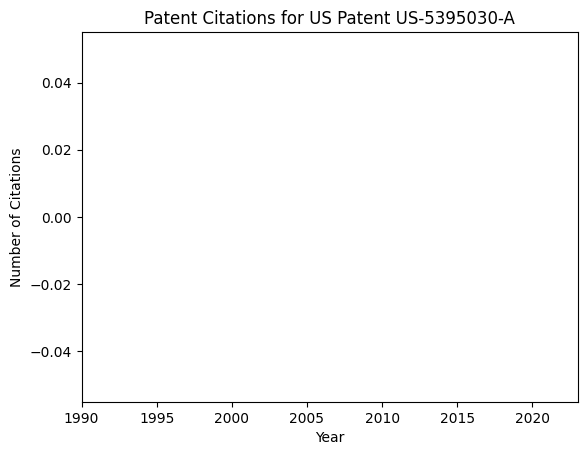

US-5487499-A
['A61B18/1402']


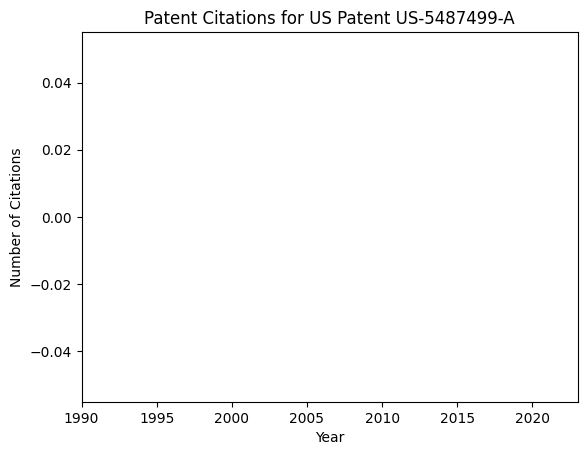

US-5397324-A
['A61B18/1402']


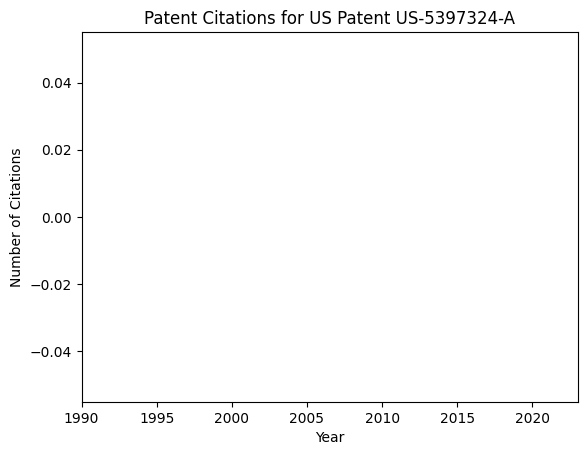

US-5411508-A
['A61B17/3403']


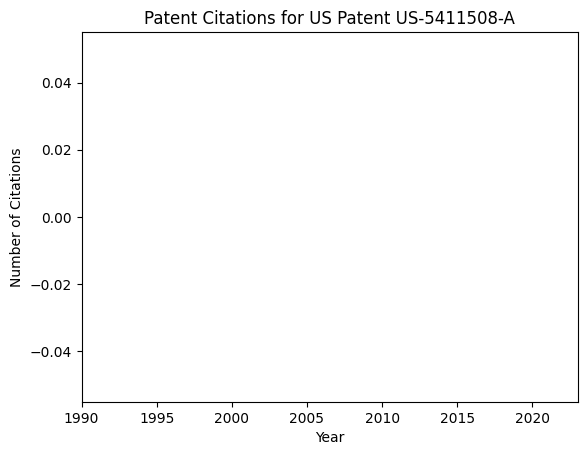

US-5484451-A
['A61B18/12']


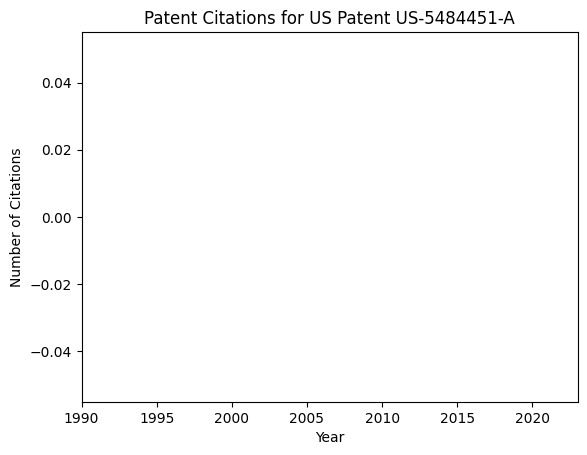

US-5608872-A
['C07K2317/73']


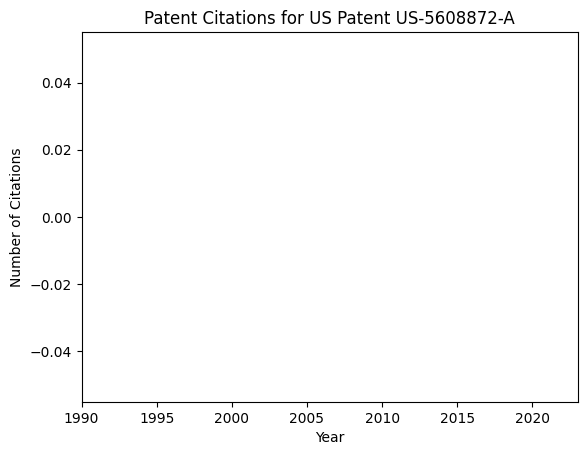

US-5318221-A
['A61B17/068']


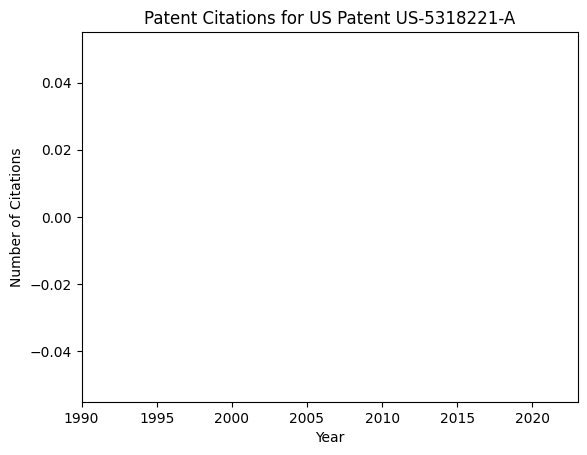

US-5391199-A
['A61B2018/0066']


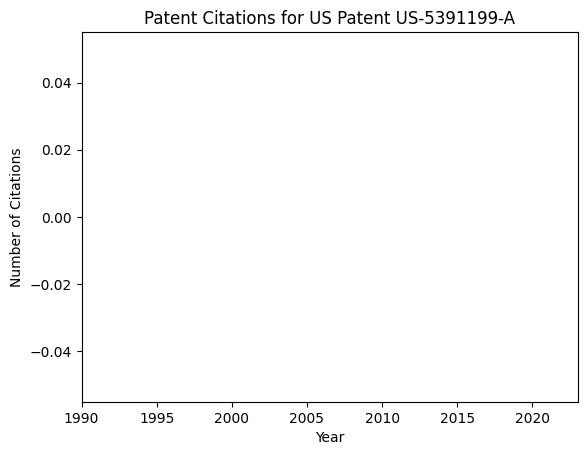

US-5520700-A
['A61B18/1206']


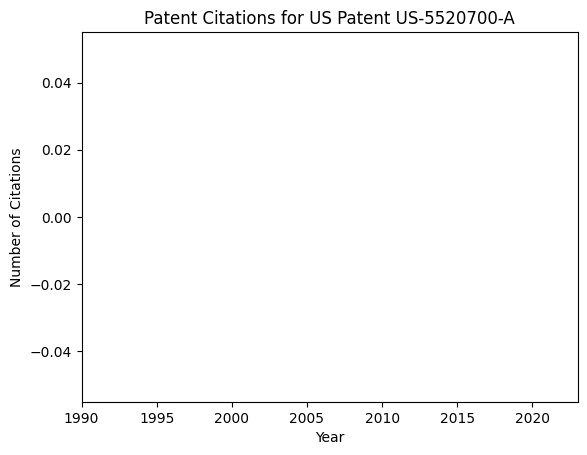

US-5649104-A
['C07K16/468']


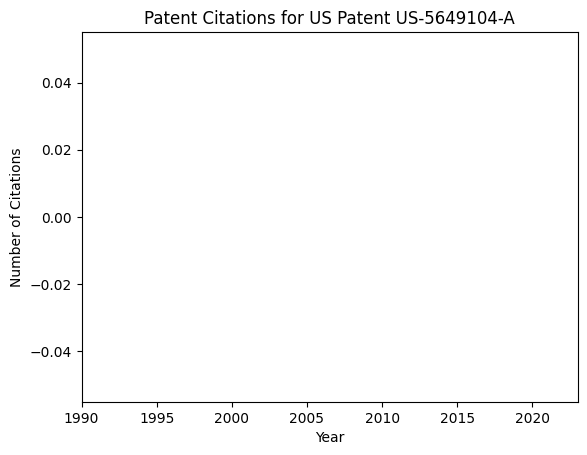

US-5326013-A
['A61B17/866']


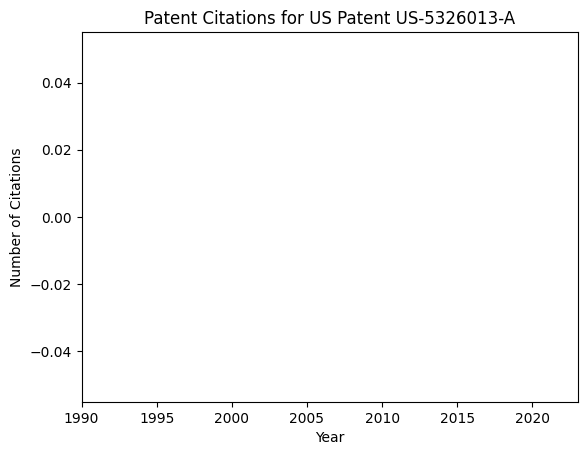

US-5330502-A
['A61B17/11']


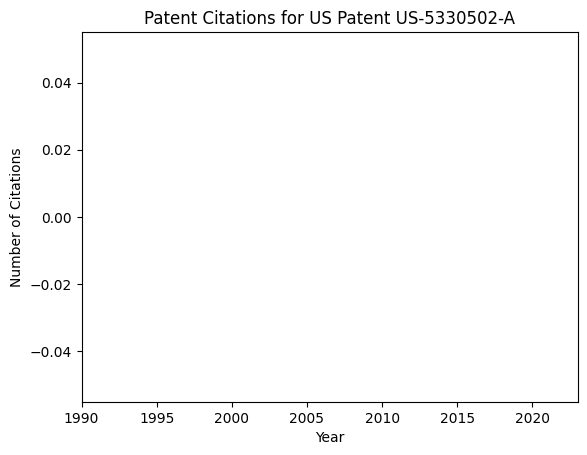

US-5484095-A
['A61B2017/0641']


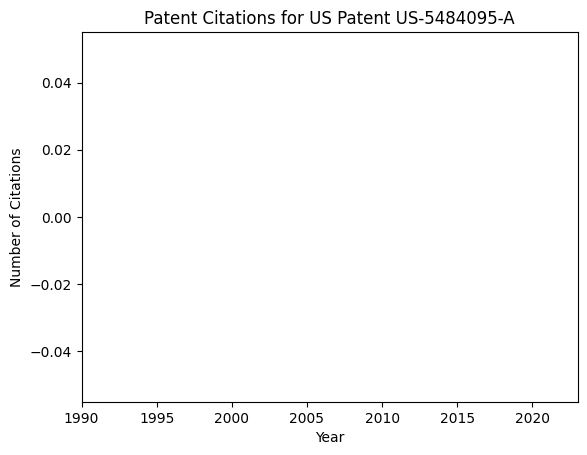

US-5400267-A
['C07K16/2866']


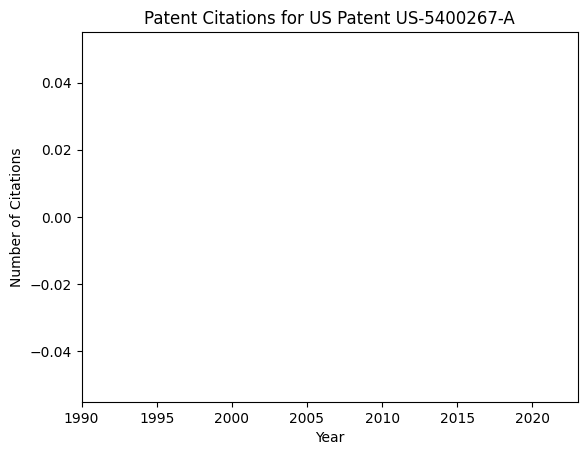

US-5425745-A
['A61B18/1402']


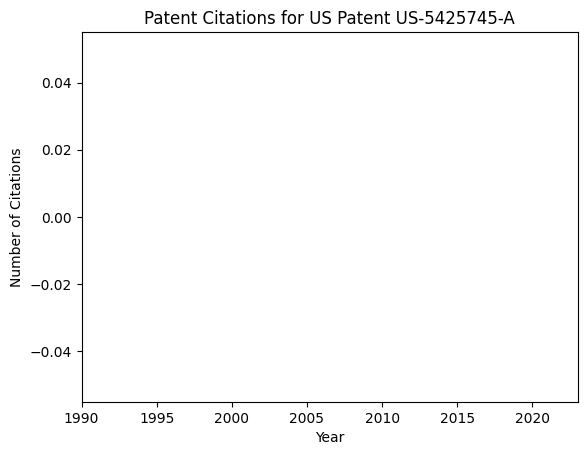

US-5271543-A
['A61B2017/00292']


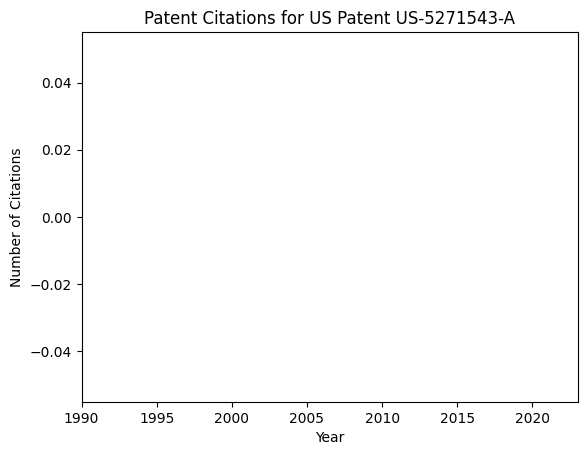

US-5560532-A
['A61B2017/0641']


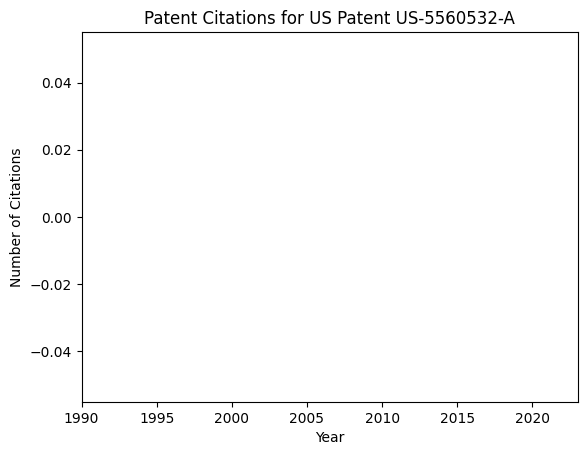

US-5485952-A
['A61B2017/00446']


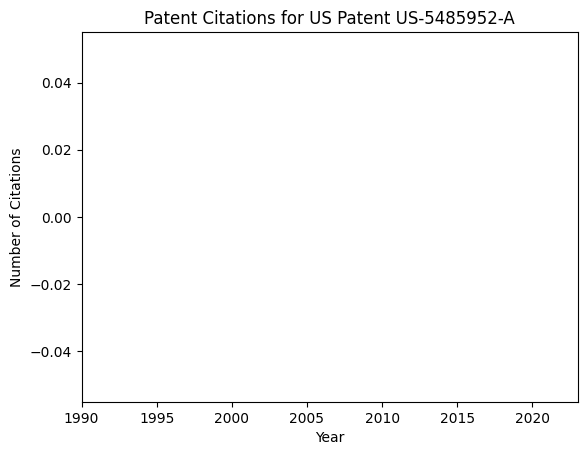

US-5443463-A
['A61B2017/07278']


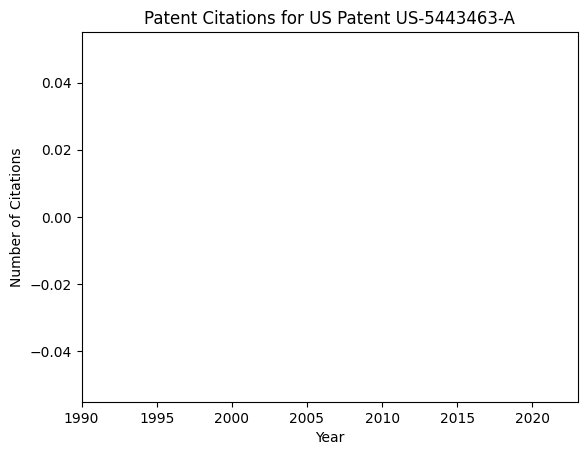

US-5309927-A
['A61B17/072']


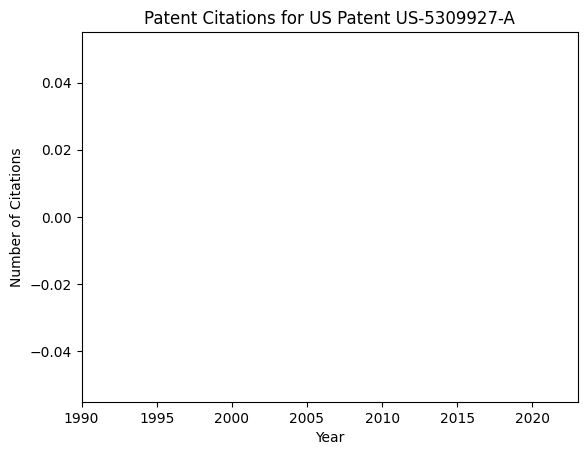

US-5242457-A
['A61B17/0491']


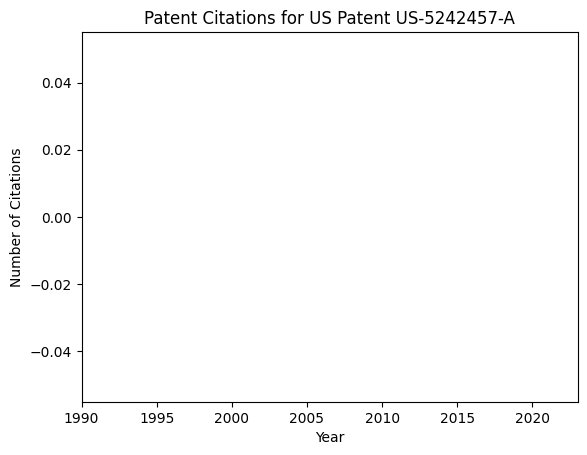

US-5397046-A
['A61B2017/2944']


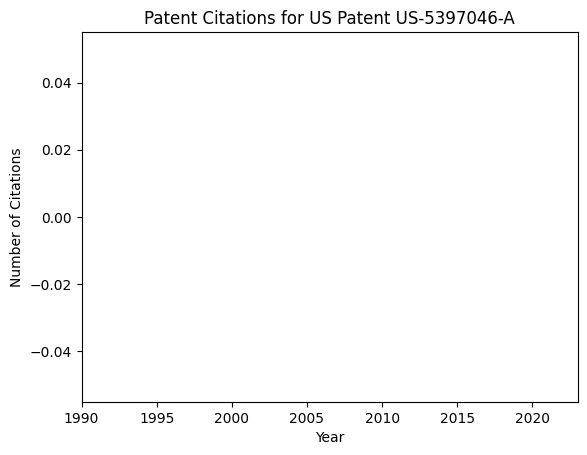

US-5503320-A
['A61B17/0644']


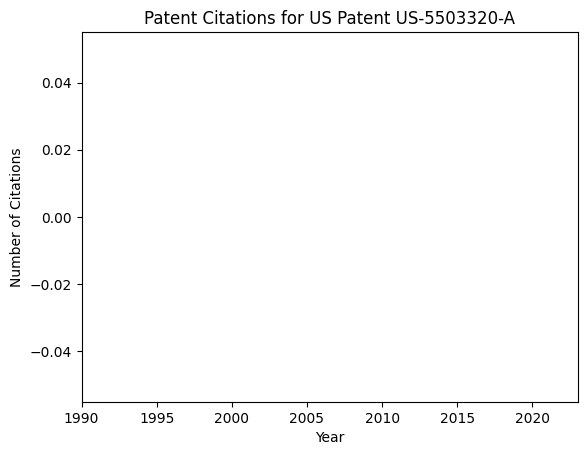

US-5332142-A
['A61B2017/0641']


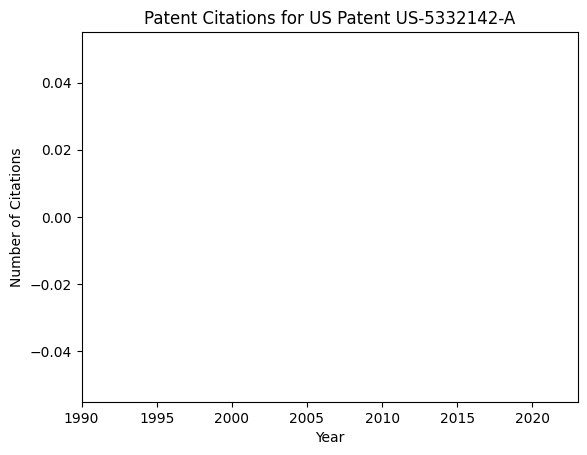

US-5263629-A
['A61B17/07207']


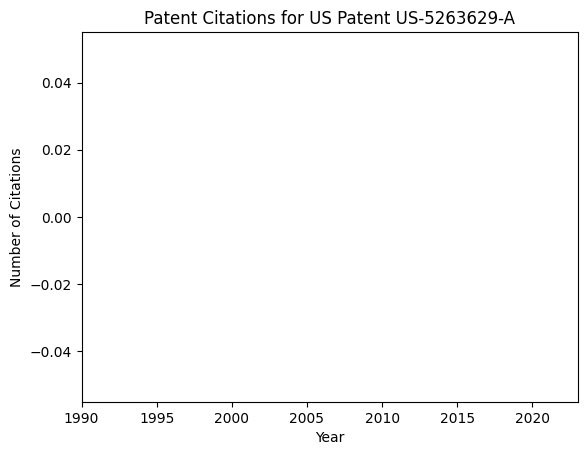

US-5334183-A
['A61B2017/2923']


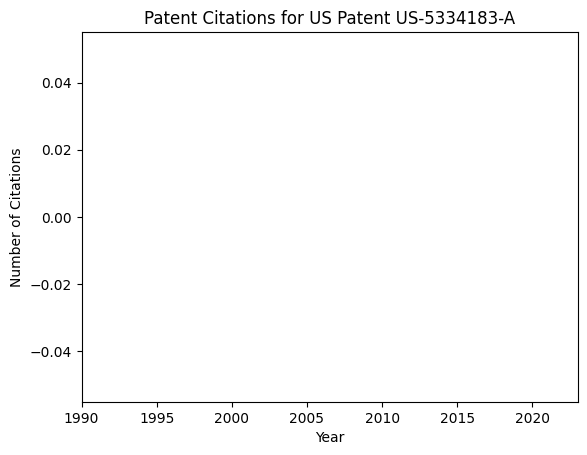

US-5292053-A
['A61B17/072']


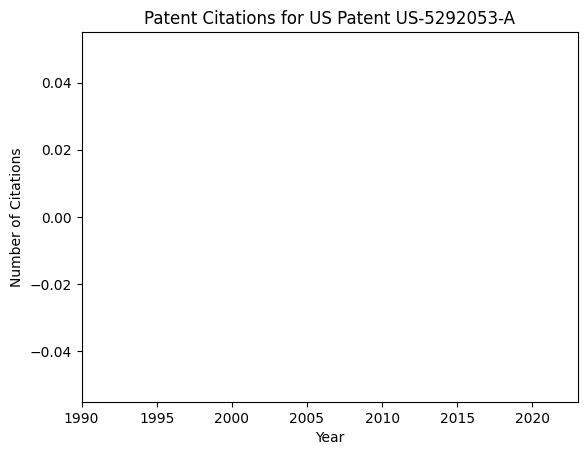

US-5209747-A
['A61B2017/2929']


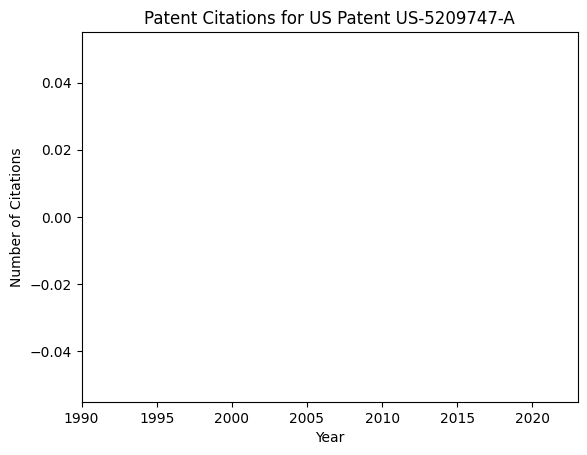

US-5392979-A
['A61B17/12109']


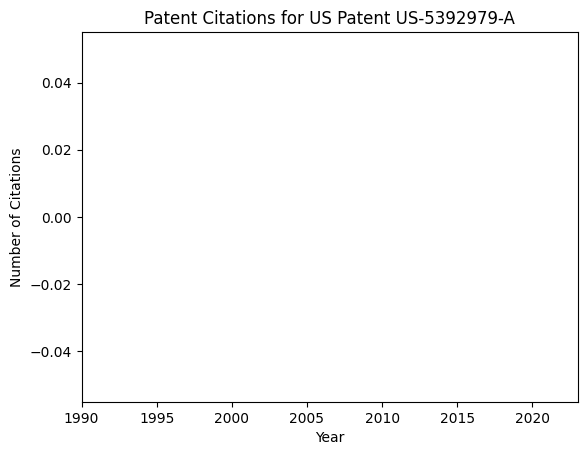

US-5478003-A
['A61B2017/0042']


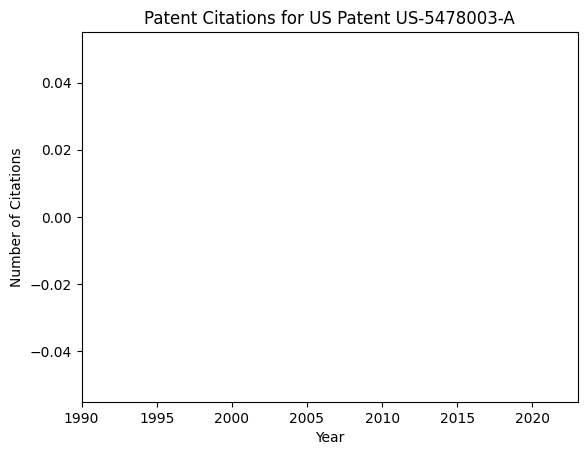

US-5395312-A
['A61B17/00234']


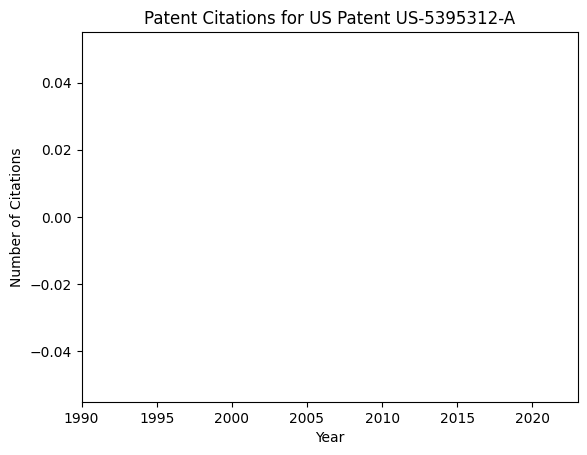

US-5221036-A
['A61B18/148']


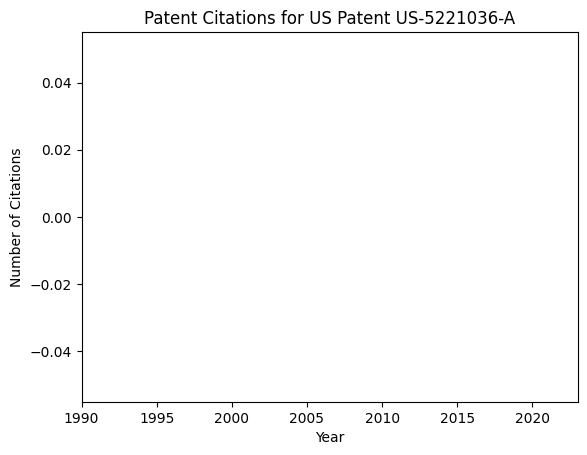

US-5281216-A
['A61B17/282']


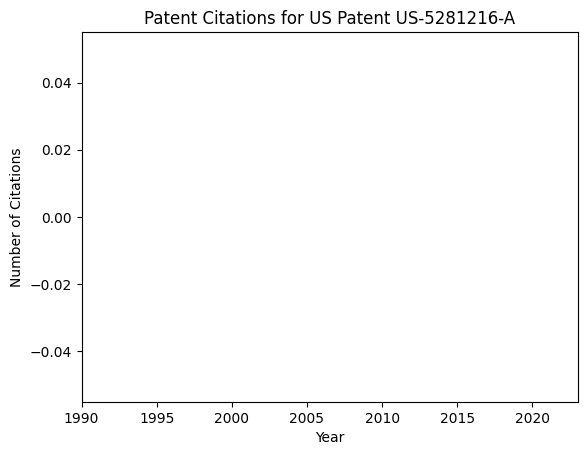

US-5441193-A
['A61B18/1402']


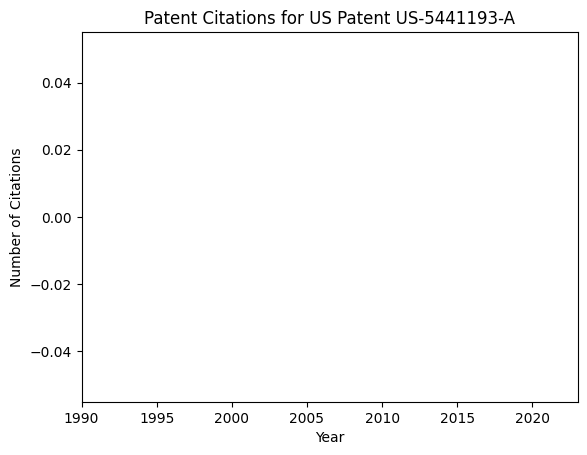

US-5383874-A
['A61B2017/07285']


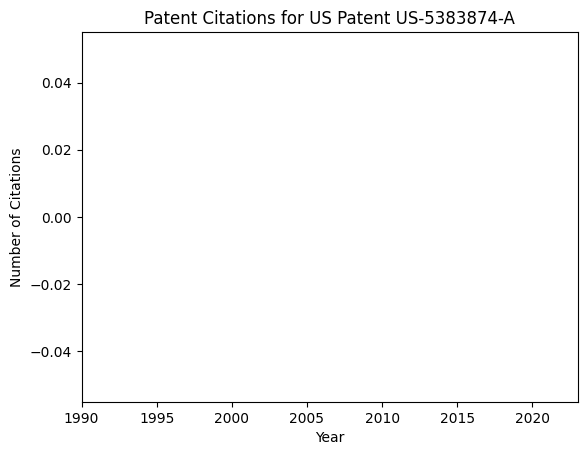

US-5271544-A
['A61B2017/00314']


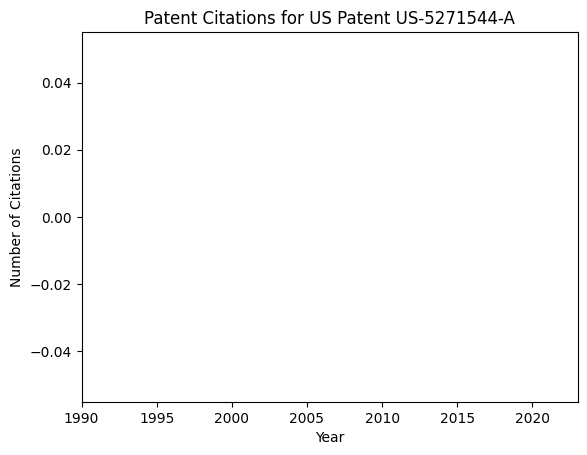

US-5478354-A
['A61B17/32']


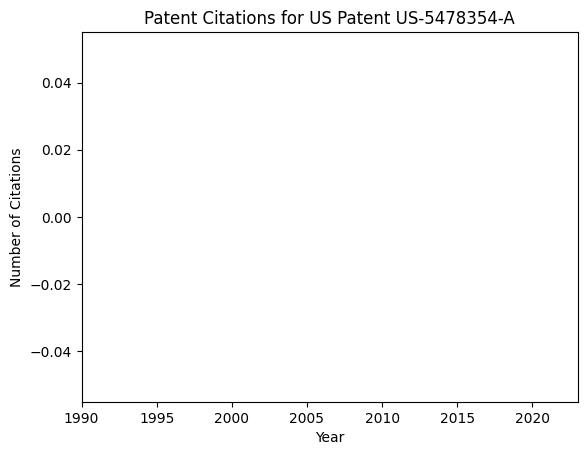

US-5208020-A
['C12N15/8509']


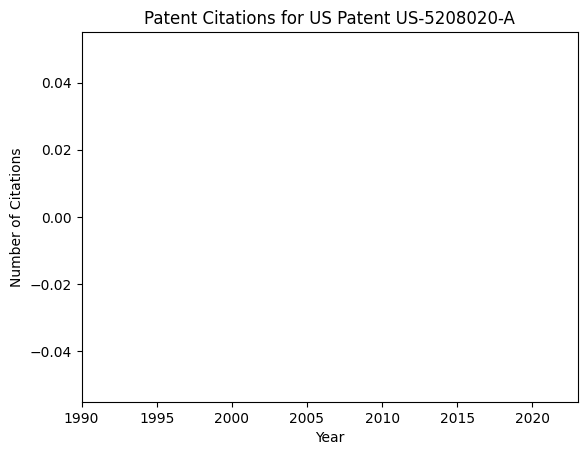

US-5408409-A
['A61B2017/2936']


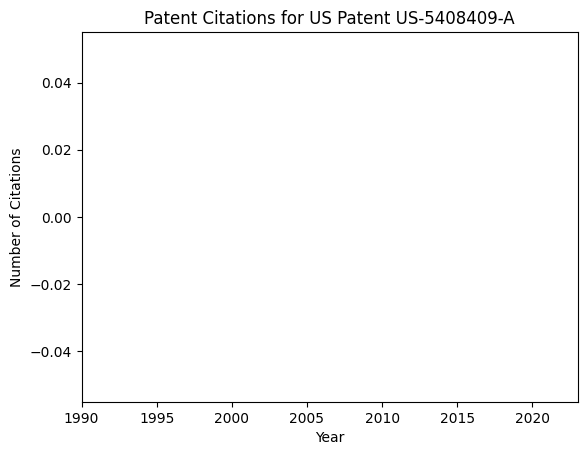

US-5339799-A
['A61B2017/32113']


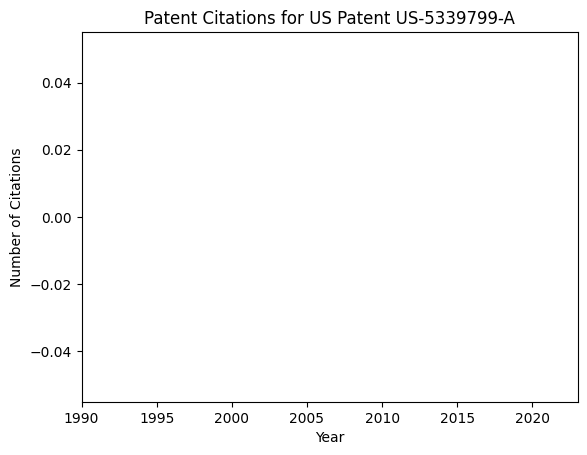

US-5539082-A
['A61F2002/30787']


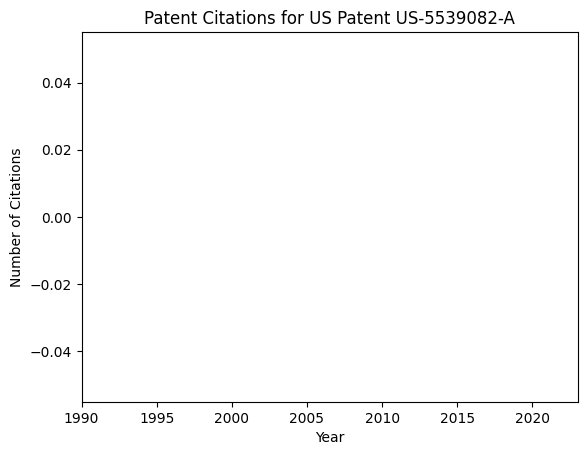

US-5405344-A
['A61B2017/00446']


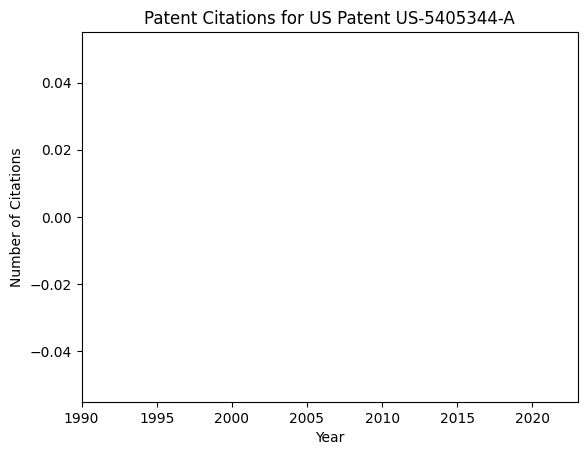

US-5217457-A
['A61B17/147']


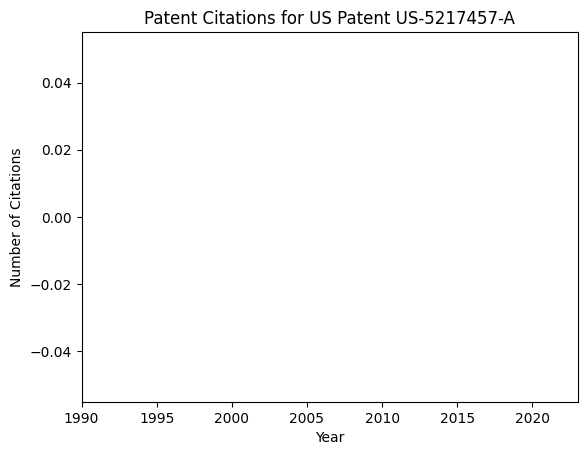

US-5333773-A
['A61B2017/07257']


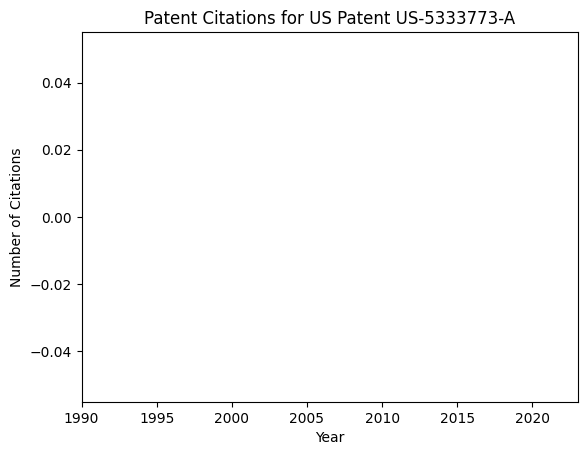

US-5352229-A
['A61B17/04']


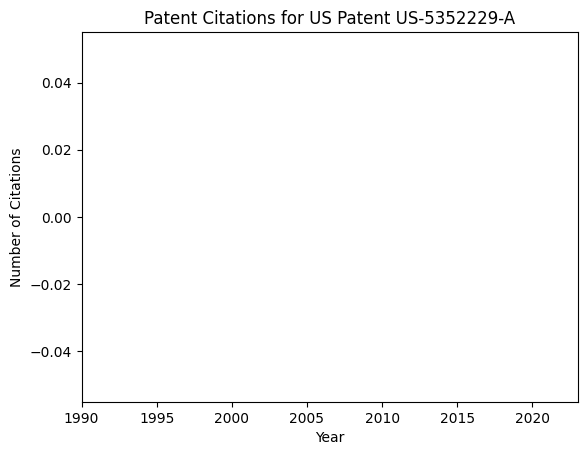

US-5374277-A
['A61B17/11']


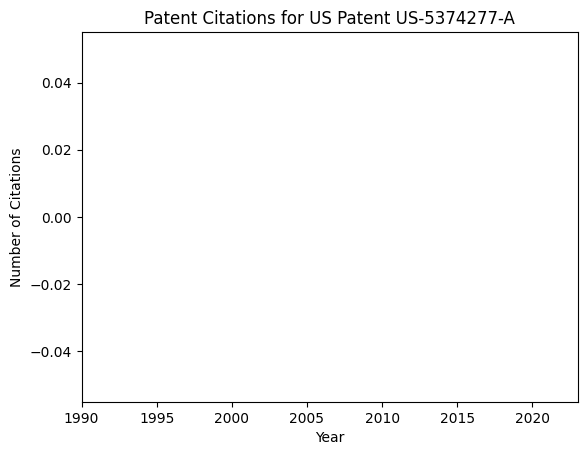

US-6407213-B1
['A61B2090/067']


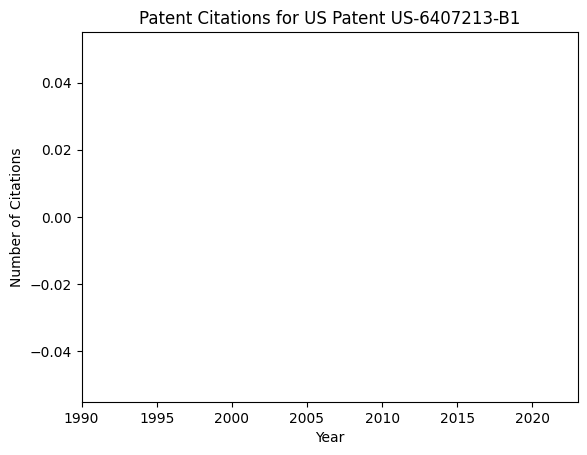

US-5468253-A
['A61B17/32']


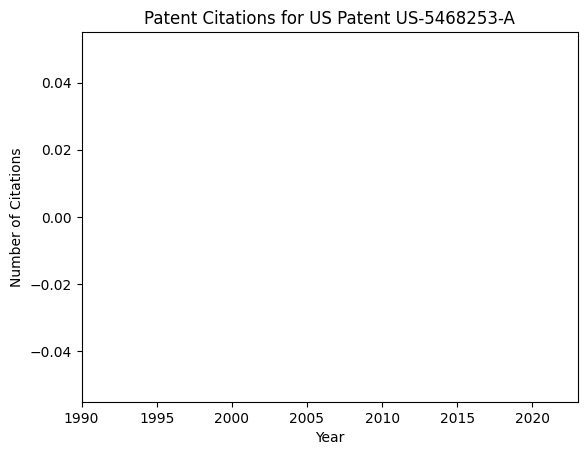

US-5275323-A
['A61B90/50']


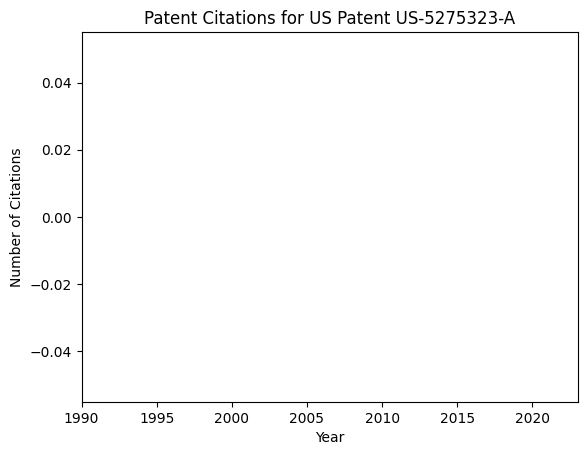

US-5383888-A
['A61B2017/07221']


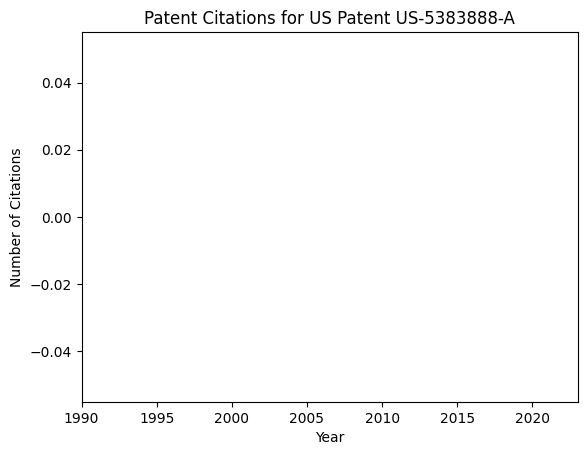

US-5368015-A
['A61B2090/037']


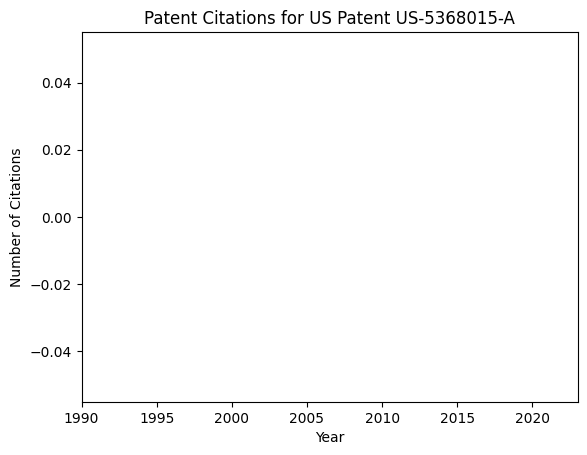

US-5366479-A
['A61B17/0642']


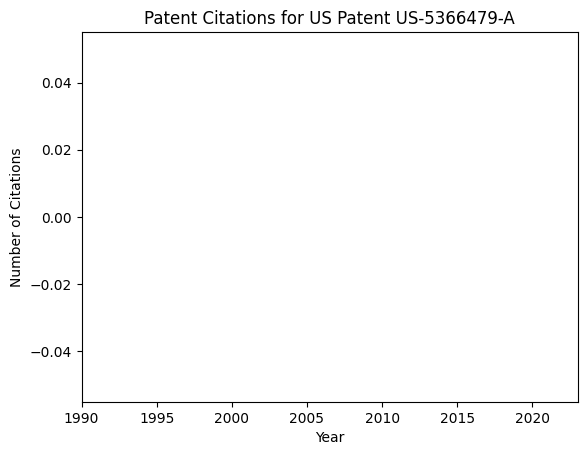

US-5195968-A
['A61B34/71']


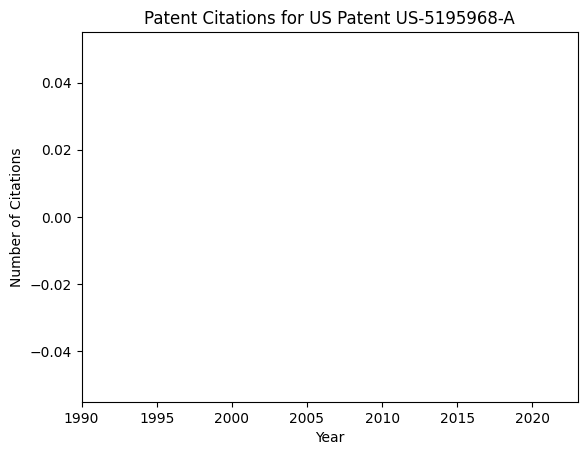

US-5381943-A
['A61B2017/00446']


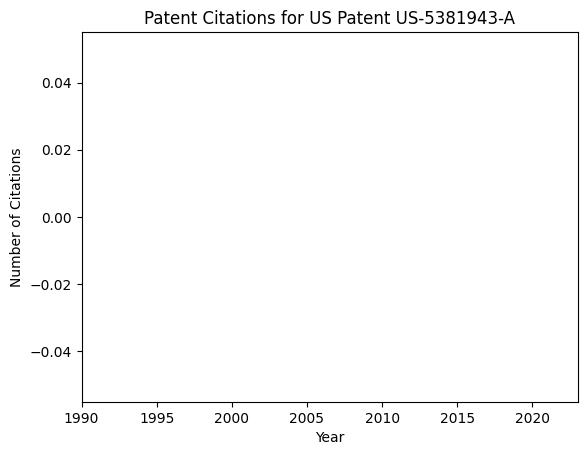

US-5413268-A
['A61B18/1402']


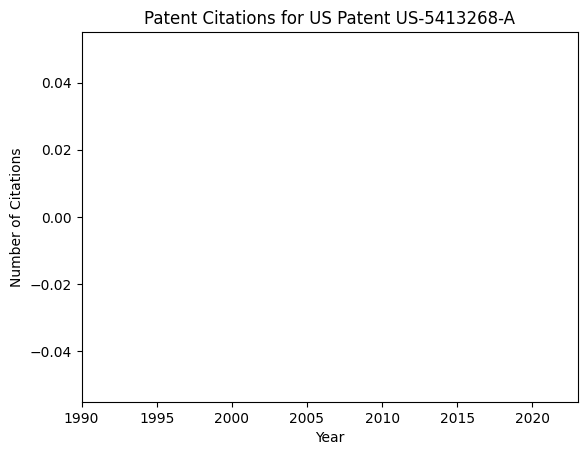

US-5503635-A
['A61B2017/00128']


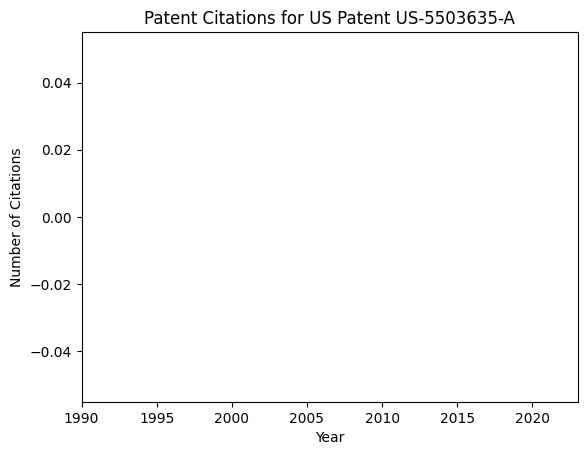

US-5381782-A
['A61B2090/0814']


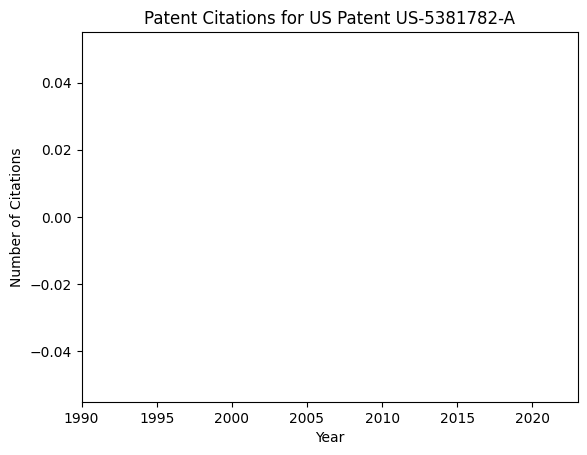

US-5246443-A
['C12Q1/6818']


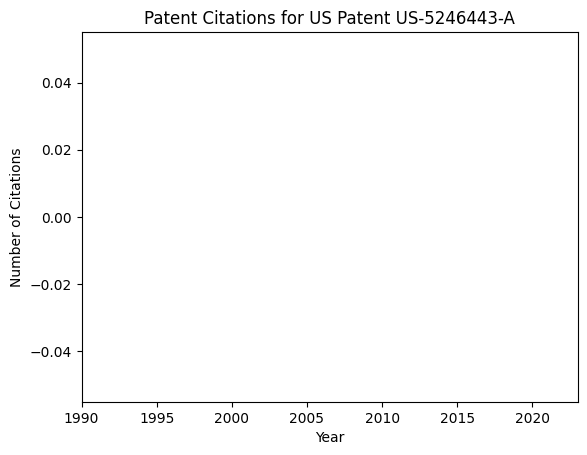

US-5376095-A
['A61B2017/07214']


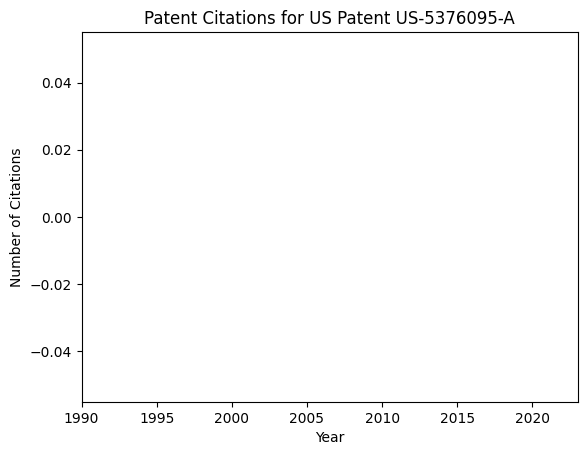

US-5562682-A
['A61B2017/0641']


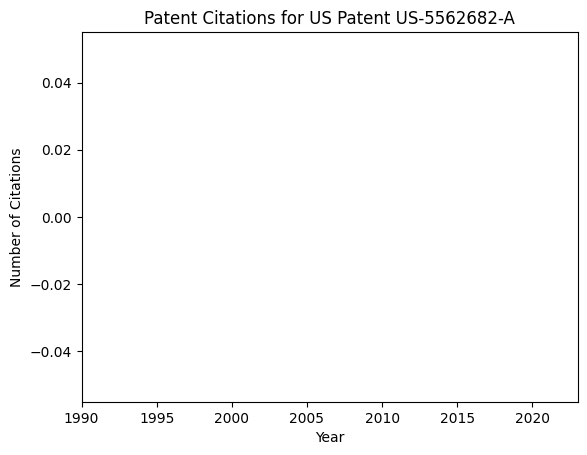

US-5364003-A
['A61B17/0491']


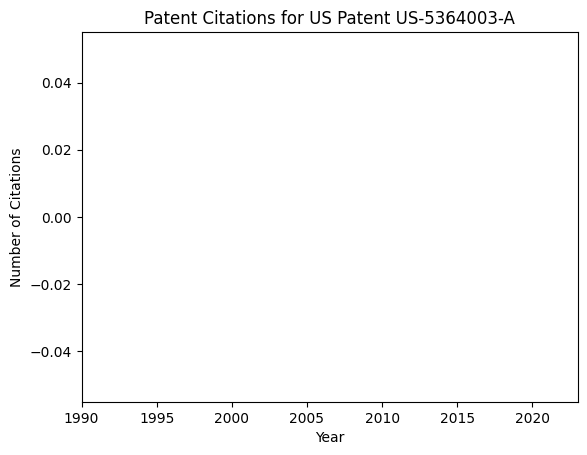

US-5314466-A
['A61B2017/00446']


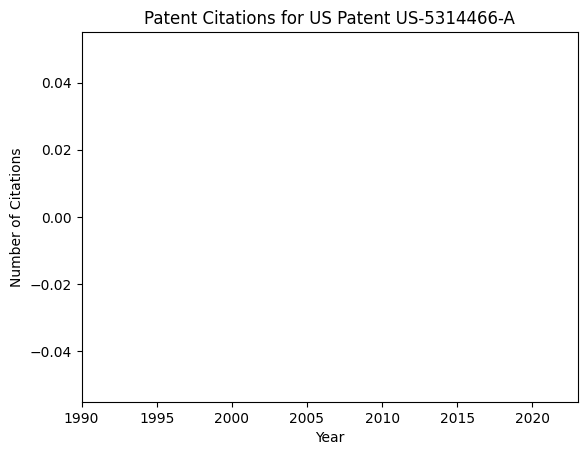

US-5395034-A
['A61B17/122']


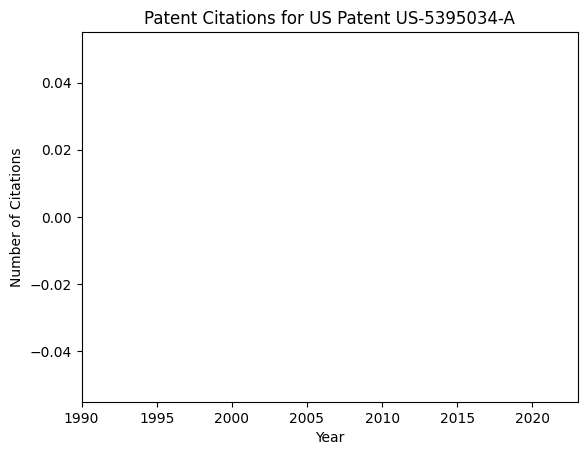

US-5348259-A
['A61P37/06']


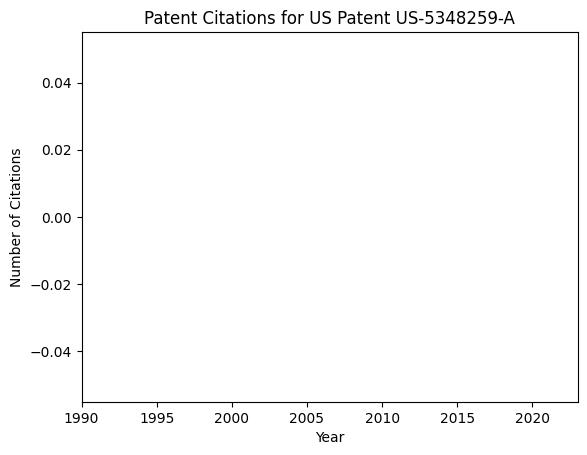

US-5332402-A
['A61B2018/00761']


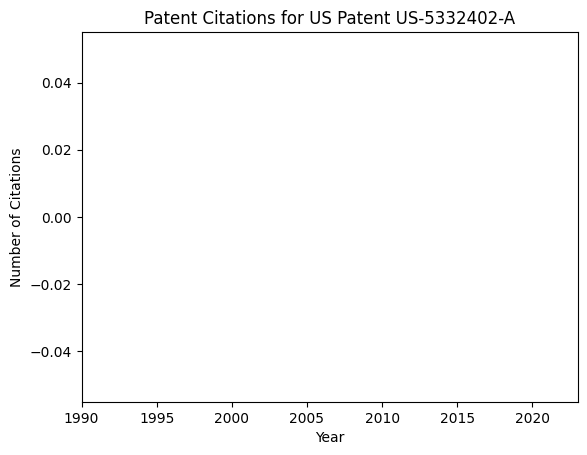

US-5304204-A
['C12Q1/001']


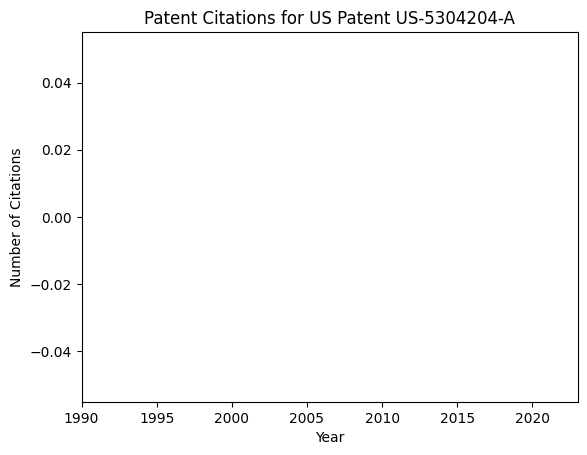

US-5405360-A
['A61B2017/00446']


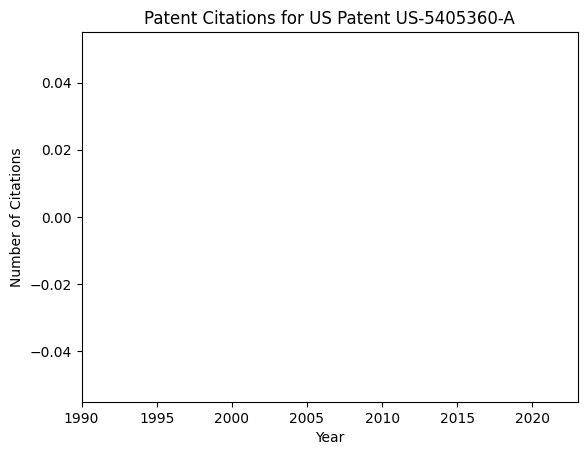

US-5405072-A
['A61B17/068']


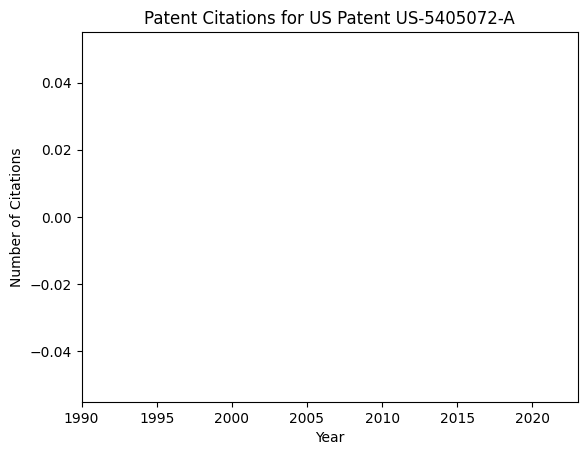

US-5350400-A
['A61B17/122']


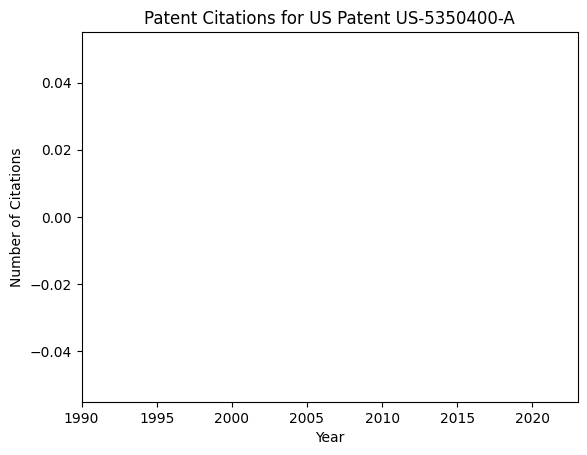

US-5312024-A
['A61B18/1445']


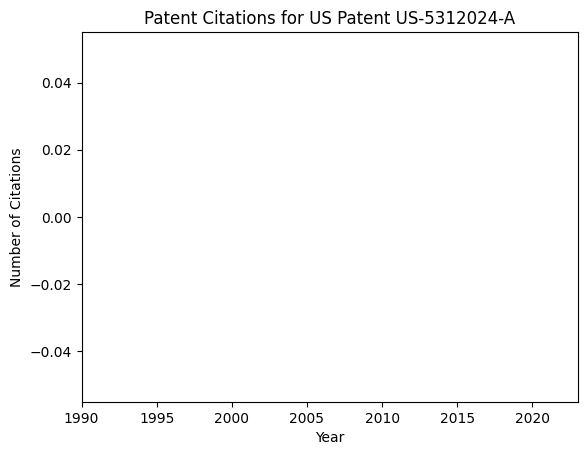

US-5358506-A
['A61B17/115']


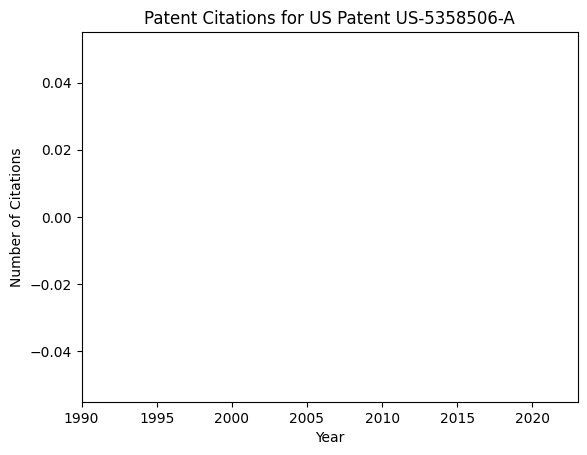

US-5449370-A
['A61B2017/0725']


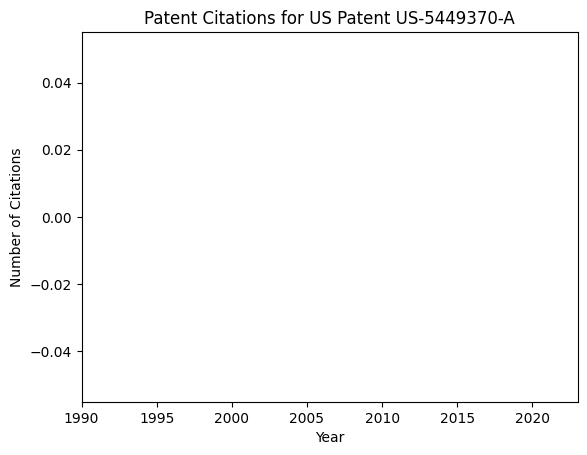

US-5192288-A
['C12N9/86']


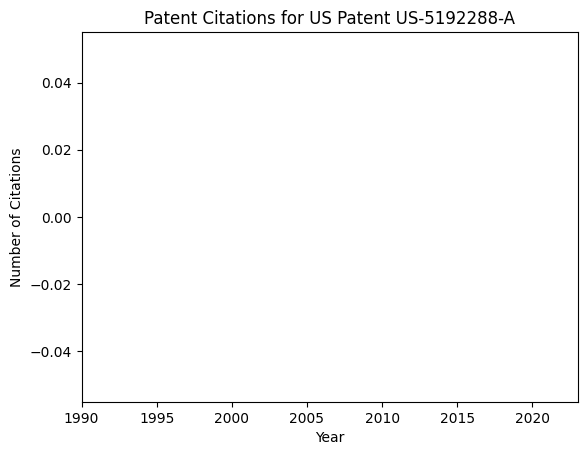

US-5282806-A
['A61B17/11']


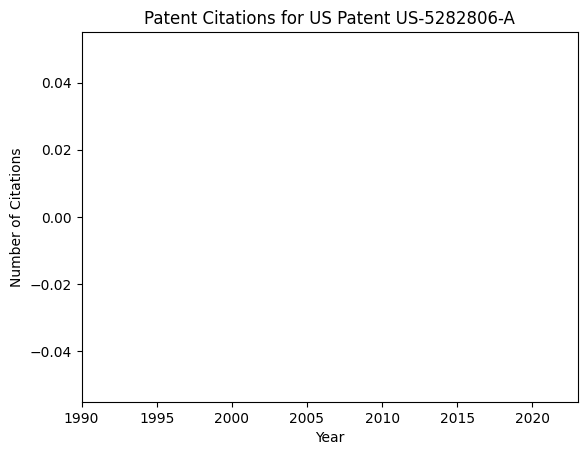

US-5341807-A
['A61B2017/2911']


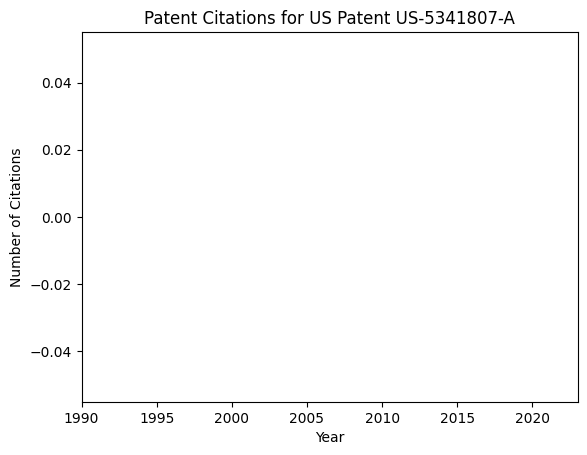

US-5370645-A
['A61B2017/2837']


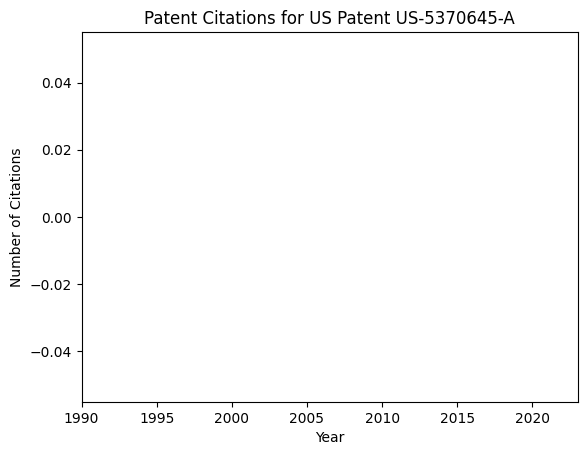

US-5336232-A
['A61B2017/07221']


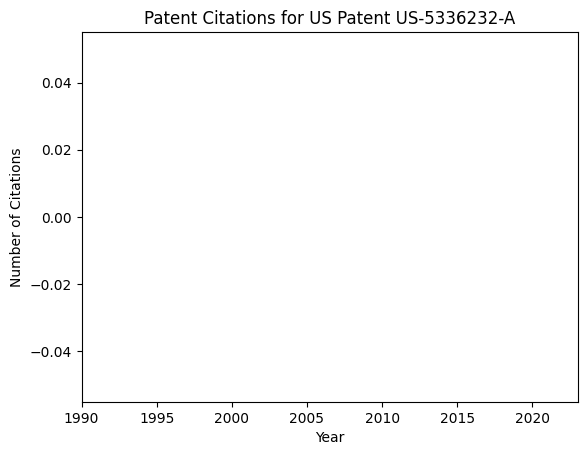

US-5431322-A
['A61B17/068']


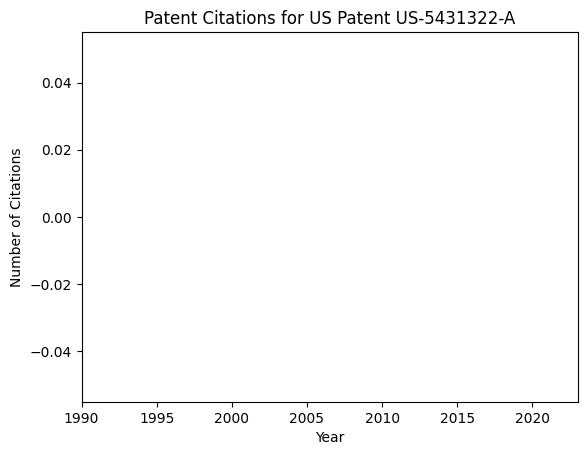

US-5441483-A
['A61B17/2909']


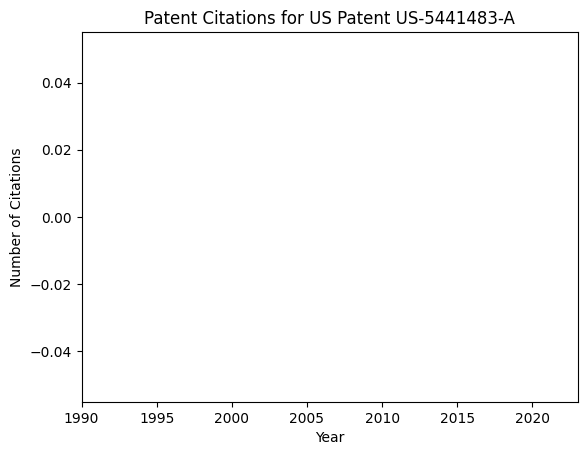

US-5527293-A
['A61B2018/1412']


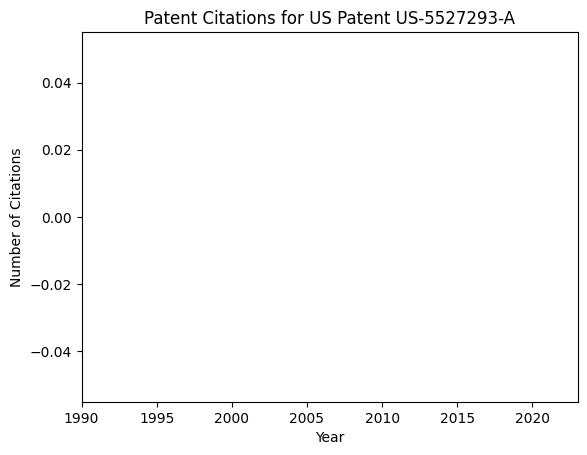

US-5364001-A
['A61B18/1402']


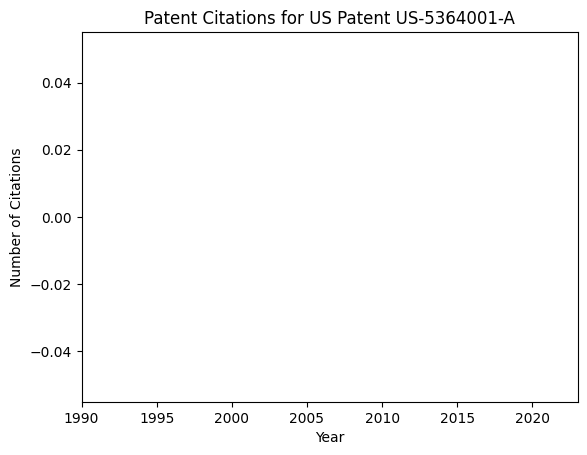

US-5465894-A
['A61B2017/00292']


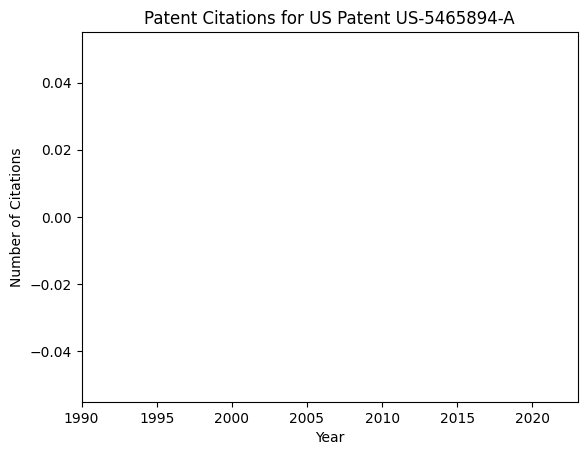

US-5259366-A
['A61B17/083']


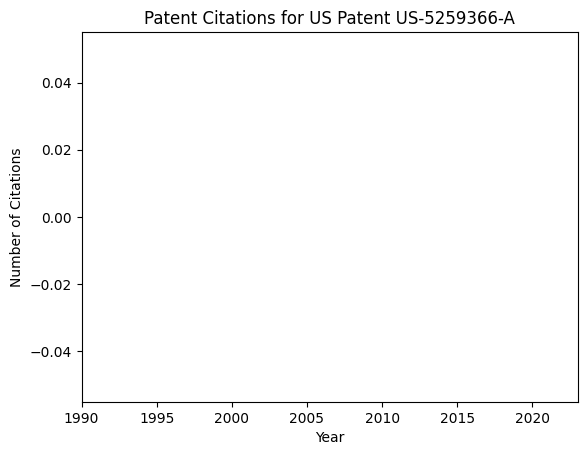

US-5342396-A
['A61B17/0491']


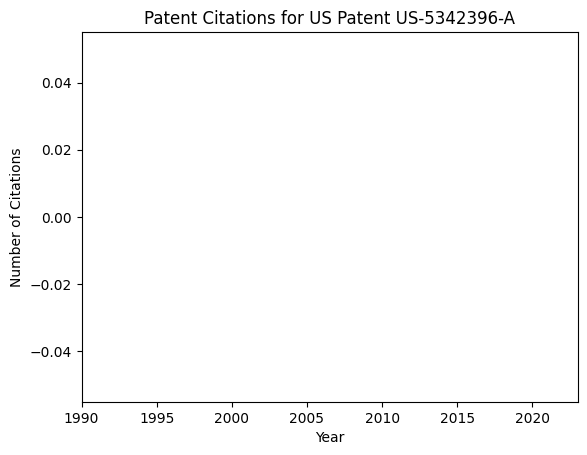

US-5407293-A
['A61F13/15']


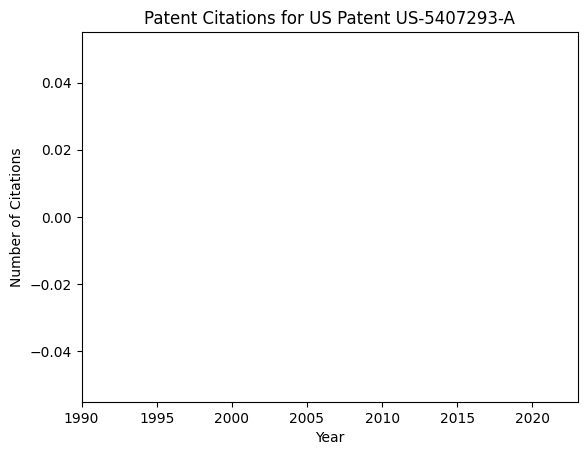

US-5379933-A
['A61B2017/2937']


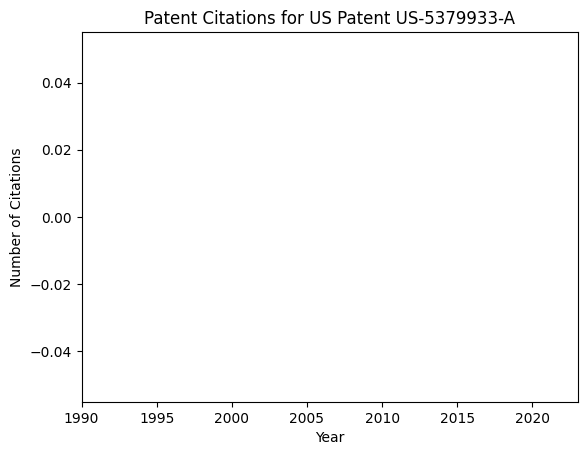

US-5344454-A
['A61B2017/3419']


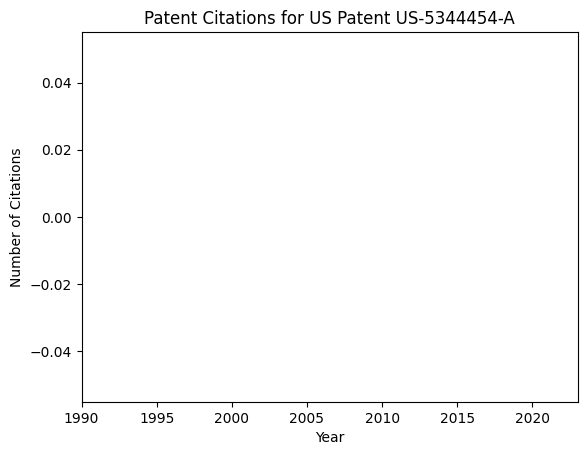

US-5441494-A
['A61B2017/320052']


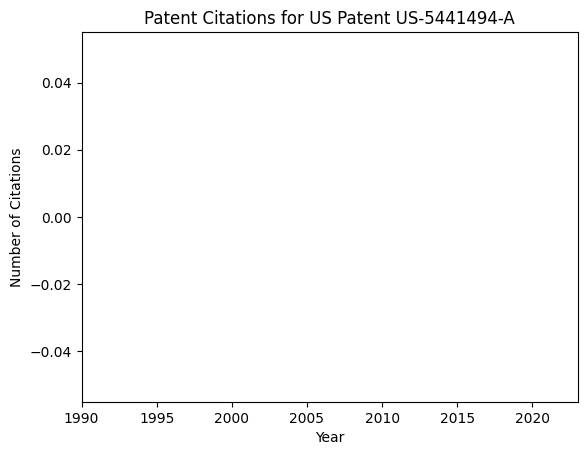

US-5264104-A
['A61M5/1723']


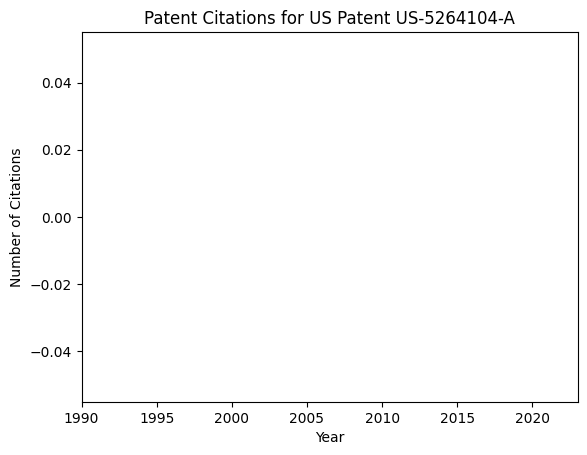

US-5321501-A
['C07K16/28']


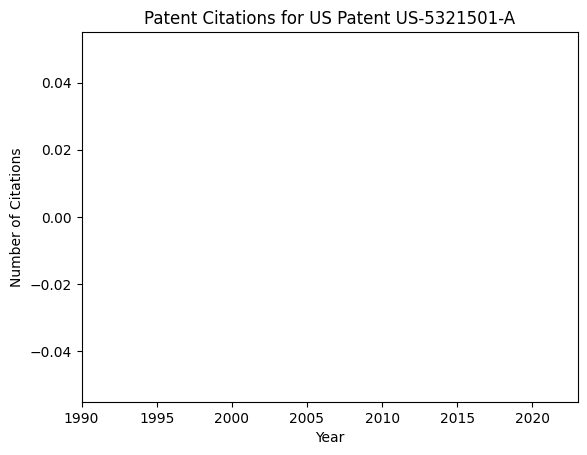

US-5330486-A
['A61B17/062']


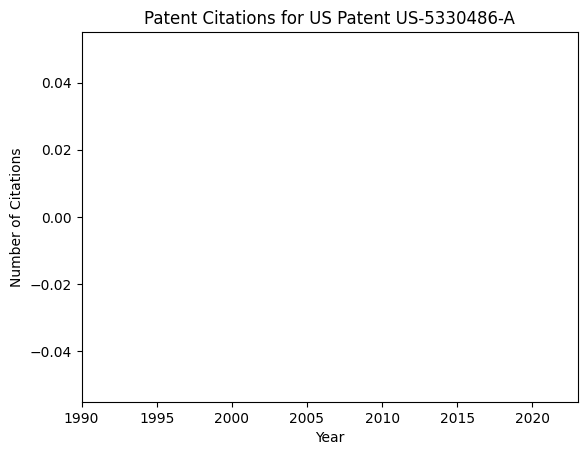

US-5542949-A
['A61B17/083']


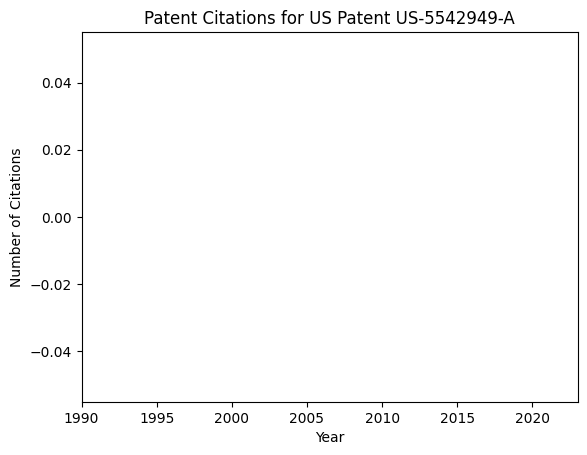

US-5489677-A
['A61F2002/30785']


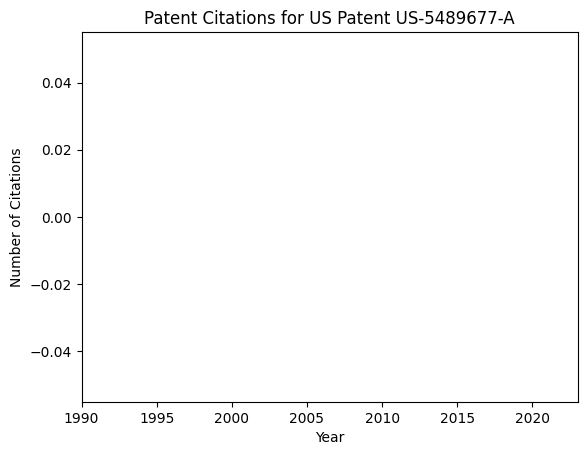

US-5236440-A
['C12N9/86']


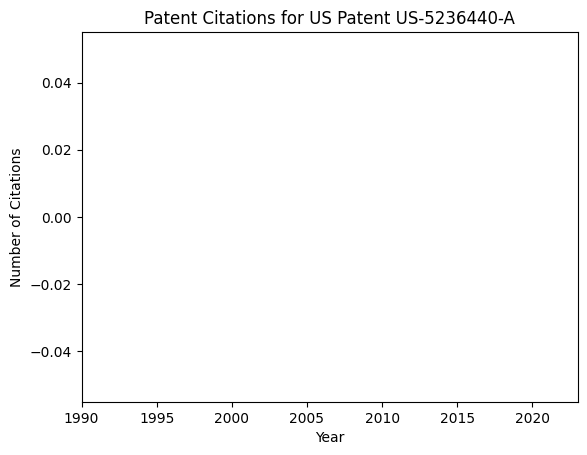

US-5342395-A
['A61B17/1285']


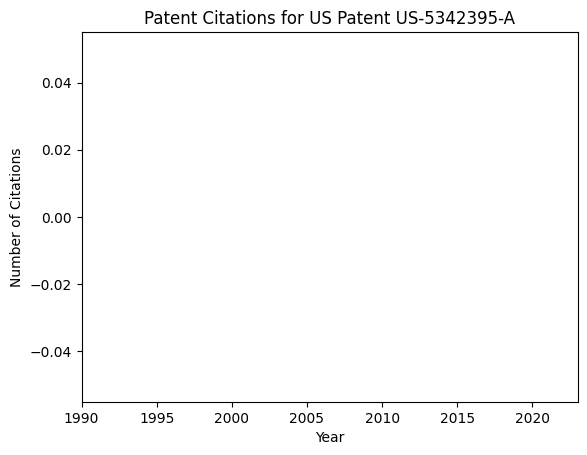

US-5342381-A
['A61B2017/2927']


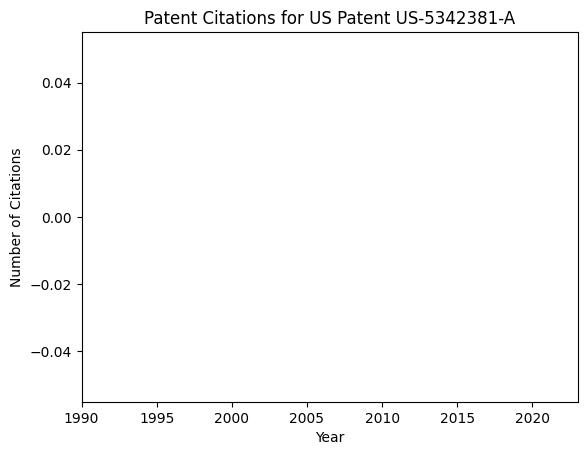

US-5270163-A
['A63F2300/5513']


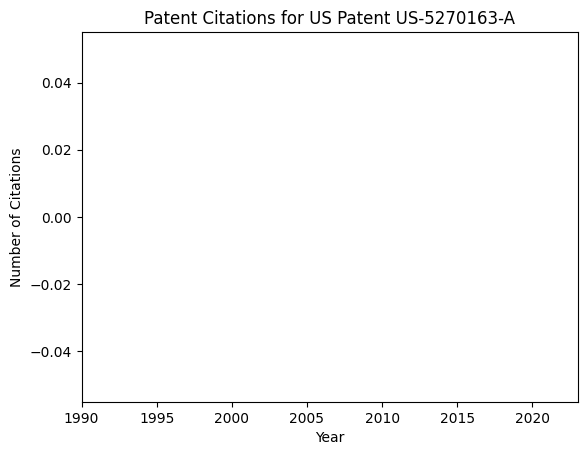

US-5464300-A
['C40B40/06']


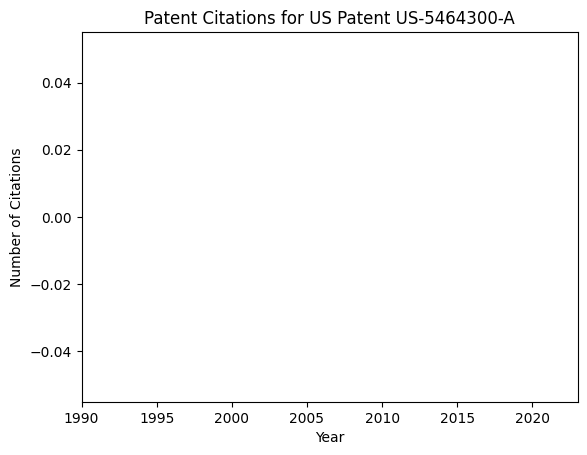

US-5321816-A
['B82Y10/00']


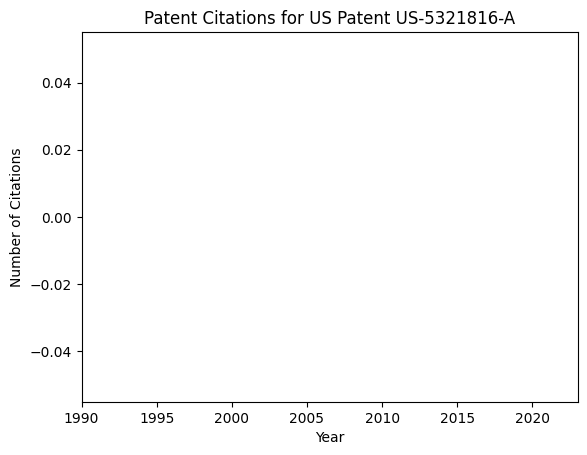

US-5470006-A
['A61B18/1402']


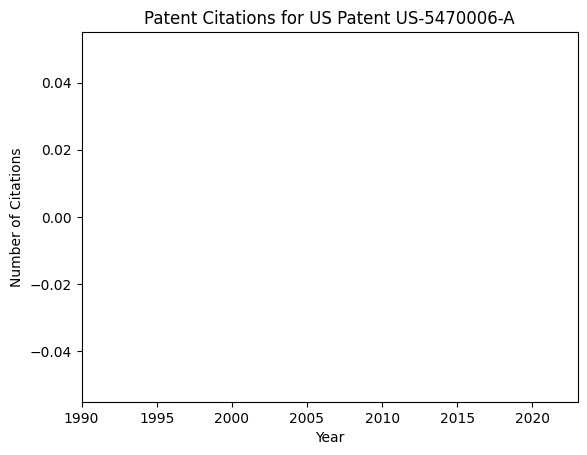

US-5400246-A
['C07K16/00']


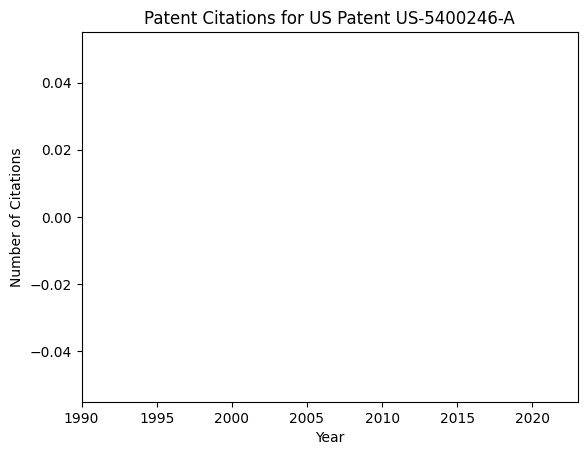

US-5299571-A
['A61B2018/00672']


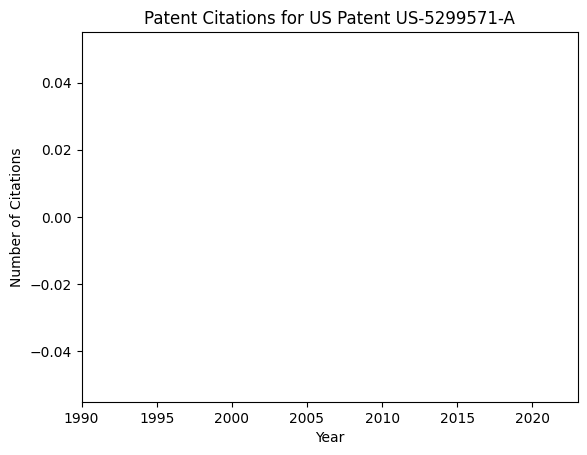

US-5389104-A
['A61B2017/07271']


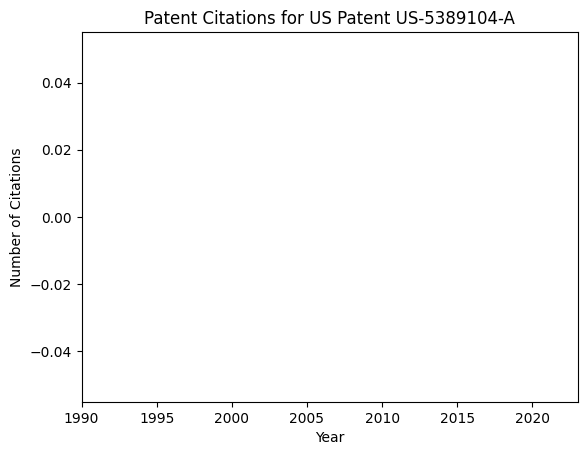

US-5350391-A
['A61B2017/0023']


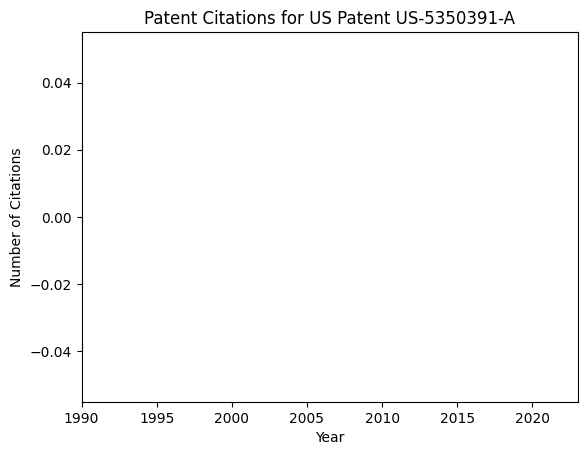

US-5587458-A
['A61K31/40']


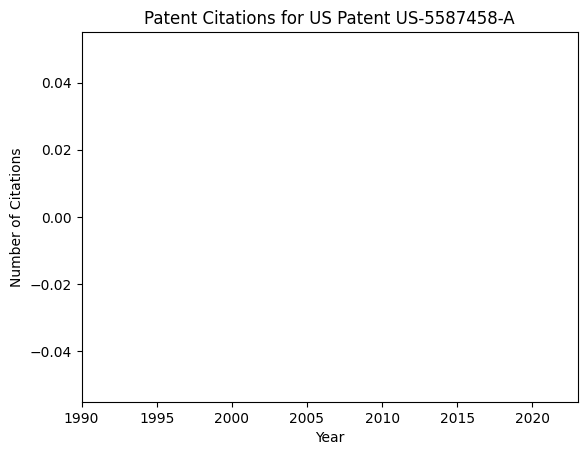

US-5275322-A
['A61B17/0684']


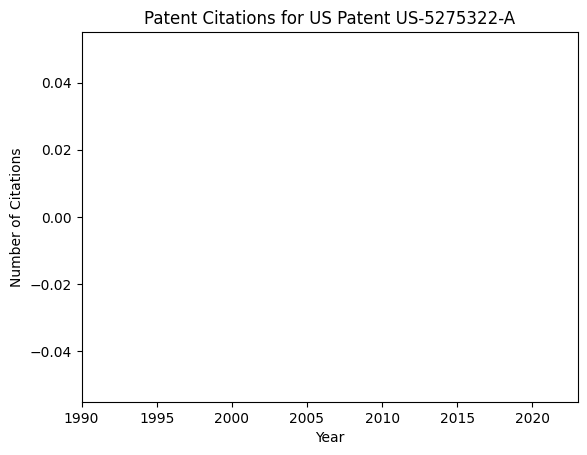

US-5290310-A
['A61B2017/00353']


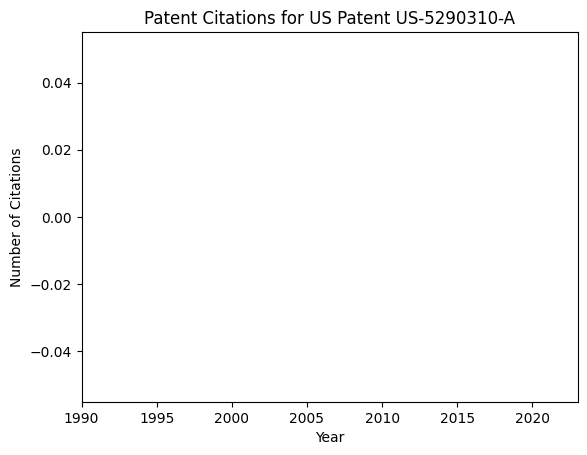

US-5544347-A
['B32B2551/08']


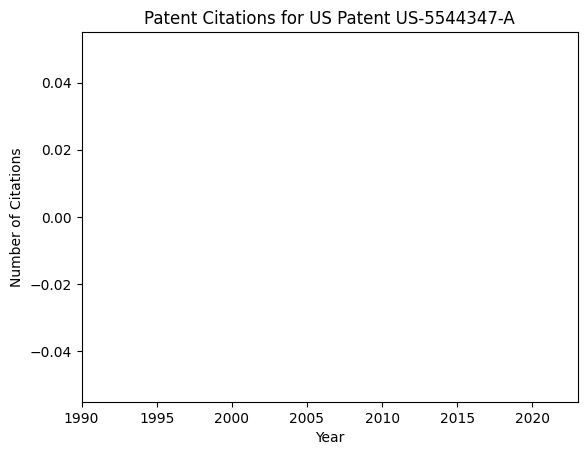

US-5550677-A
['A63F2009/0004']


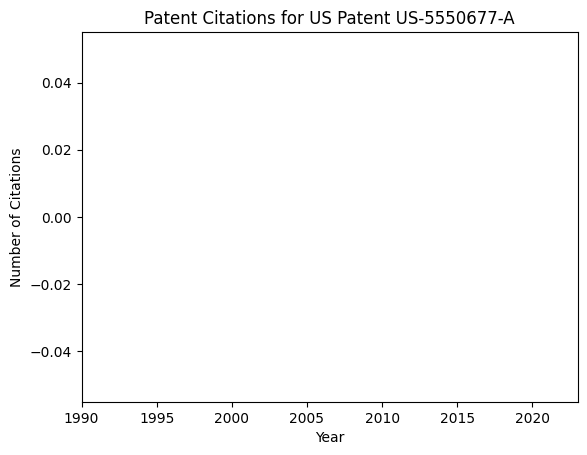

US-5284128-A
['A61B17/00234']


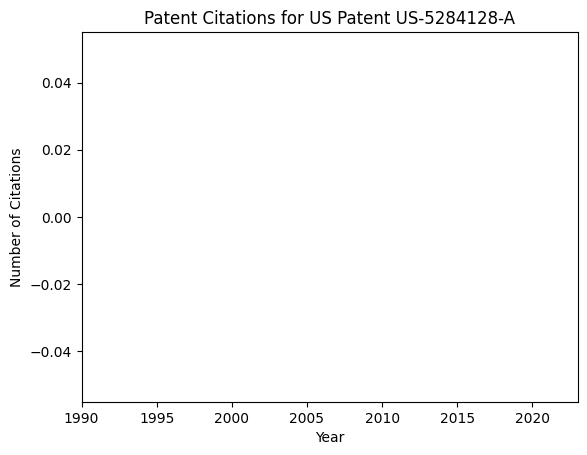

US-5383851-A
['A61B5/0031']


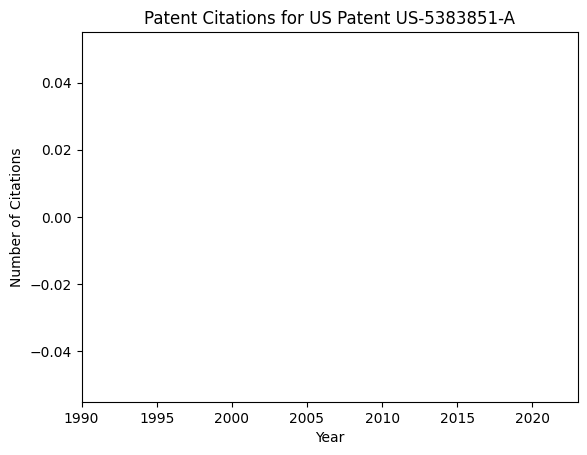

US-5431668-A
['C12N9/0069']


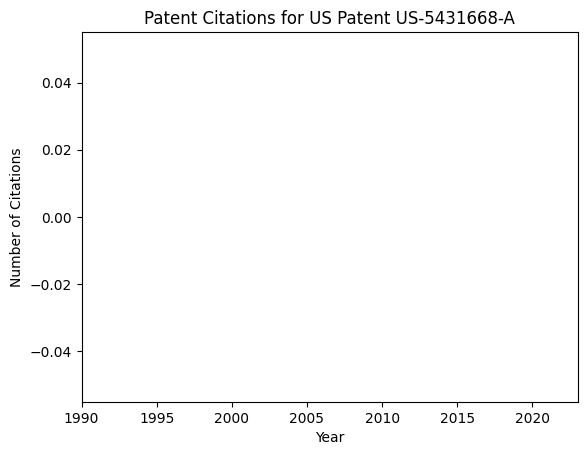

US-5356786-A
['A61M5/1723']


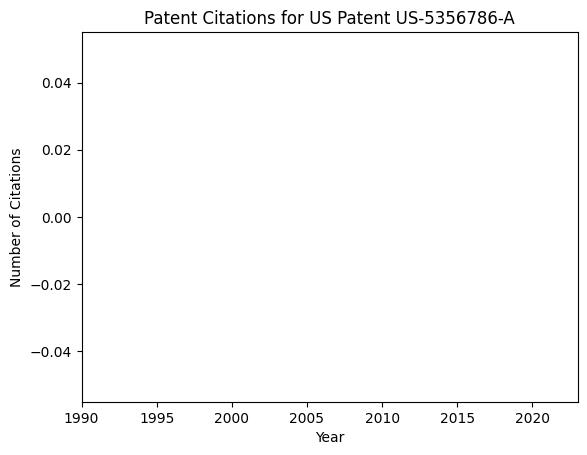

US-5399491-A
['A61N1/06']


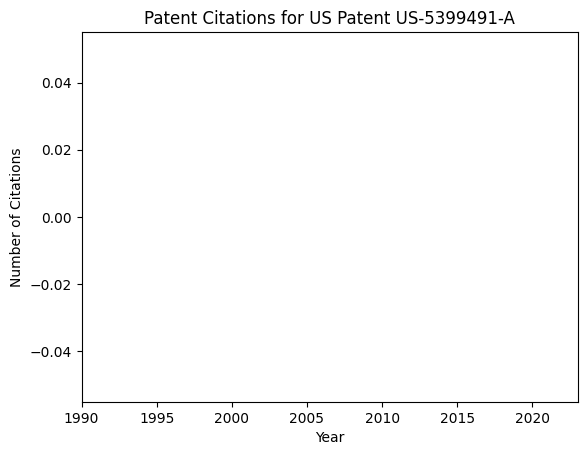

US-5290271-A
['A61B2090/0804']


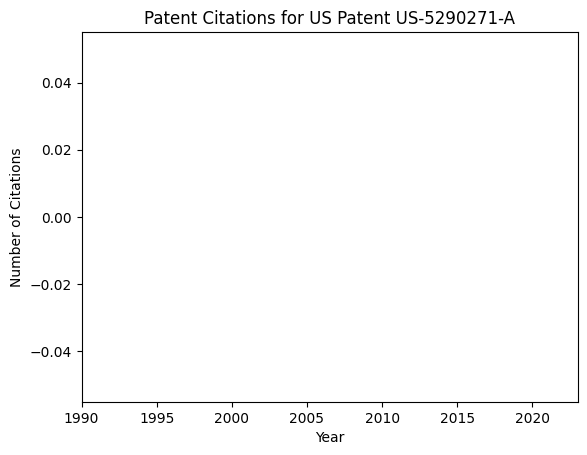

US-5409498-A
['A61B2017/0641']


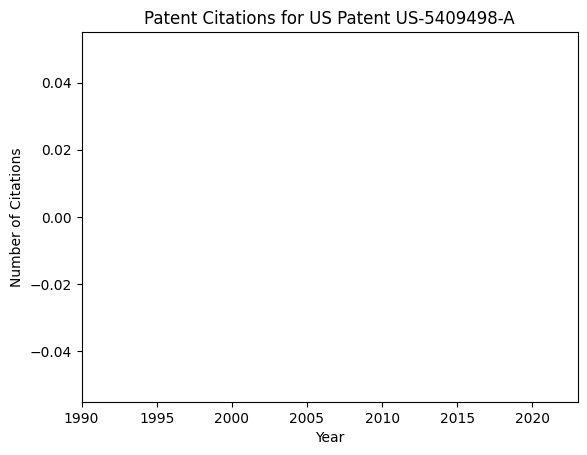

US-5447513-A
['C12N9/0069']


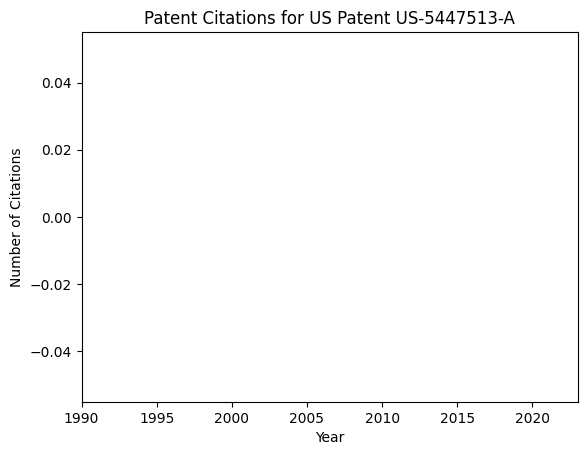

US-5454101-A
['C07D417/12']


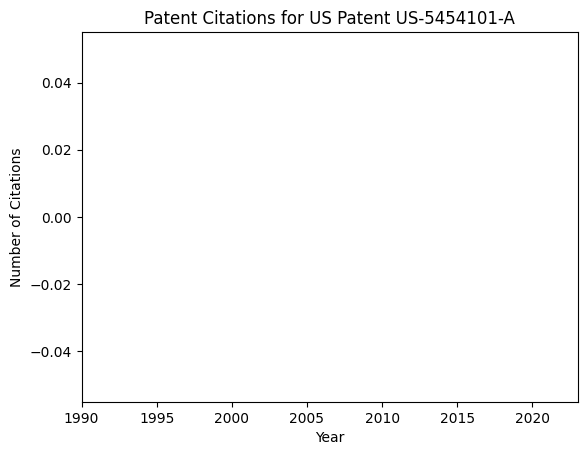

US-5423471-A
['A61B17/068']


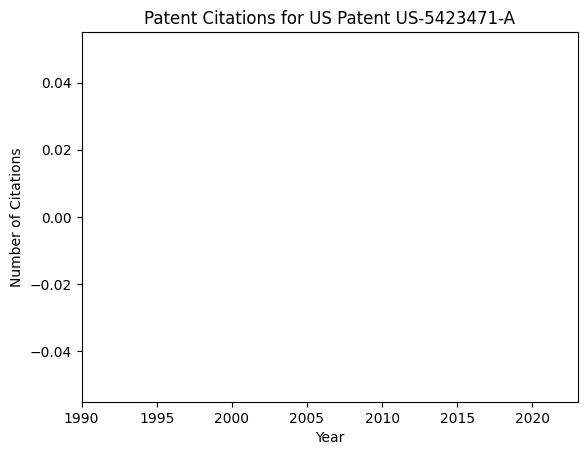

US-5352238-A
['A61B17/320783']


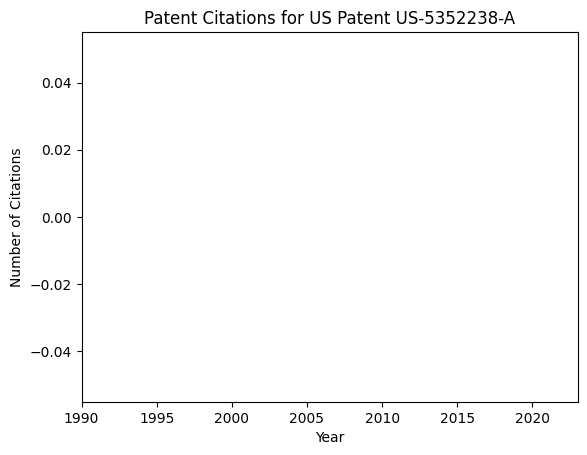

US-5490505-A
['A61B2017/3445']


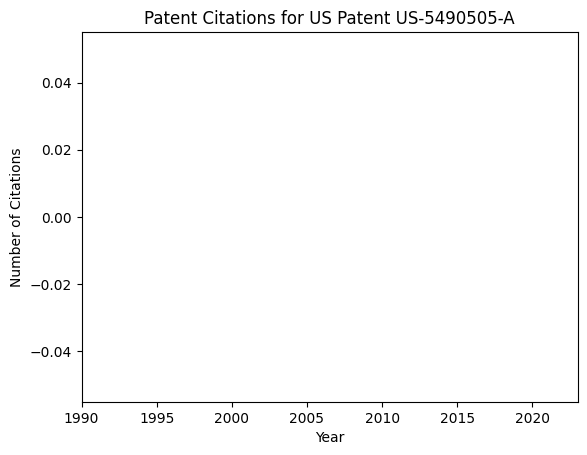

US-5422567-A
['A61B2017/2913']


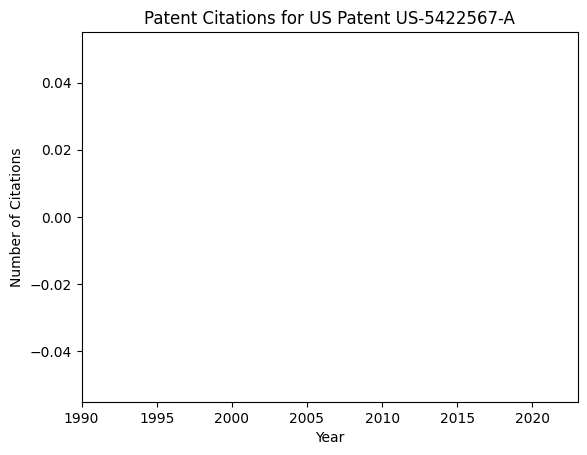

256


'\nfor i in u_labels:\n    filtered_label = clustering_unified[label == i]\n    plt.scatter(filtered_label["Time"], filtered_label["Times_90"],label = i)\nplt.title("Clustered Data comparing CPC classification codes and time taken to reach 1500 citations")\nplt.xlabel("Time until 1500 citations (years)")\nplt.ylabel("Binarized CPC Classification")\nplt.show()\n'

In [177]:
u_labels = np.unique(label)
fig = plt.figure(figsize = (8,4))
count = 0
#A graphing function of all patents must be done by two year ranges otherwise everything goes boom
#clustering_backup = pd.read_csv("1994-1996/clustering1994-1996.csv")

for i in label:
    if i == 0:
        pub_code = clustering_backup['Pub'].to_list()[count]
        print(pub_code)
        #pub_code = temp['Pub'].to_list()[newint]
        #print(pub_code)
        print(convert_to_cpc(lb, converted_cpc[count], 195))
        graph_patents(df, pub_code)
    count +=1
print(count)
"""
for i in u_labels:
    filtered_label = clustering_unified[label == i]
    plt.scatter(filtered_label["Time"], filtered_label["Times_90"],label = i)
plt.title("Clustered Data comparing CPC classification codes and time taken to reach 1500 citations")
plt.xlabel("Time until 1500 citations (years)")
plt.ylabel("Binarized CPC Classification")
plt.show()
"""